### 1. Import Libraries

In [2]:
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

### 2. Load the Dataset

##### Connect the SQL Server to get the data

In [4]:
# Eshtablishing the connection :

conn = pyodbc.connect(
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=DESKTOP-DDTGTVD\SQLEXPRESS02;'
    r'DATABASE=BANK_DB;'
    r'Trusted_Connection=yes;'
)

In [6]:
# If connection is succesfull, print True
if conn:
    print('True')

True


In [8]:
df1 = "SELECT * FROM Internal_Bank_Data "
df2 = "SELECT * FROM External_Data"

In [10]:
df1 = pd.read_sql(df1, conn)
df2 = pd.read_sql(df2, conn)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7128\346327068.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(df1, conn)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7128\346327068.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(df2, conn)


In [13]:
df1.head(2)

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,CC_TL,Consumer_TL,Gold_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,Other_TL,Age_Oldest_TL,Age_Newest_TL
0,13263.0,3.0,2.0,1.0,0.0,1.0,0.0,0.333,0.333,0.667,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,32.0,7.0
1,13264.0,4.0,4.0,0.0,0.0,0.0,0.0,0.000,0.000,1.000,...,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,29.0,20.0


In [15]:
df2.head(2)

,PROSPECTID,time_since_recent_payment,num_times_delinquent,max_recent_level_of_deliq,num_deliq_6mts,num_deliq_12mts,num_deliq_6_12mts,max_deliq_6mts,max_deliq_12mts,num_times_30p_dpd,...,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
0,708.0,72.0,1.0,17.0,1.0,1.0,0.0,17.0,17.0,0.0,...,0.462,0.667,0.316,0.286,1.0,0.0,CC,CC,670.0,P2
1,709.0,72.0,11.0,268.0,0.0,0.0,0.0,0.0,0.0,11.0,...,0.000,0.000,0.000,0.000,0.0,0.0,ConsumerLoan,others,676.0,P2


### 3. Data Exploration :

##### For df1

In [81]:
# Basic informationabout the dataset:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PROSPECTID            51336 non-null  float64
 1   Total_TL              51336 non-null  float64
 2   Tot_Closed_TL         51336 non-null  float64
 3   Tot_Active_TL         51336 non-null  float64
 4   Total_TL_opened_L6M   51336 non-null  float64
 5   Tot_TL_closed_L6M     51336 non-null  float64
 6   pct_tl_open_L6M       51336 non-null  float64
 7   pct_tl_closed_L6M     51336 non-null  float64
 8   pct_active_tl         51336 non-null  float64
 9   pct_closed_tl         51336 non-null  float64
 10  Total_TL_opened_L12M  51336 non-null  float64
 11  Tot_TL_closed_L12M    51336 non-null  float64
 12  pct_tl_open_L12M      51336 non-null  float64
 13  pct_tl_closed_L12M    51336 non-null  float64
 14  Tot_Missed_Pmnt       51336 non-null  float64
 15  Auto_TL            

In [83]:
# Summary 
df1.describe()

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,CC_TL,Consumer_TL,Gold_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,Other_TL,Age_Oldest_TL,Age_Newest_TL
count,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,...,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51296.000000,51296.000000
mean,25668.500000,4.858598,2.770415,2.088184,0.736754,0.428919,0.184574,0.089095,0.577542,0.422458,...,0.124981,1.136084,1.561847,0.070146,0.282511,2.844904,2.013694,1.089762,45.376969,15.780022
std,14819.571046,7.177116,5.941680,2.290774,1.296717,0.989972,0.297414,0.205635,0.379867,0.379867,...,0.505201,2.227997,5.376434,0.340861,0.858168,6.187177,3.198322,2.417496,41.737151,21.995676
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12834.750000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,4.000000
50%,25668.500000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.556000,0.444000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,33.000000,8.000000
75%,38502.250000,5.000000,3.000000,3.000000,1.000000,1.000000,0.308000,0.053000,1.000000,0.750000,...,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000,2.000000,1.000000,64.000000,17.000000
max,51336.000000,235.000000,216.000000,47.000000,27.000000,19.000000,1.000000,1.000000,1.000000,1.000000,...,27.000000,41.000000,235.000000,10.000000,29.000000,235.000000,55.000000,80.000000,392.000000,392.000000


In [85]:
df1.nunique()

PROSPECTID              51336
Total_TL                  107
Tot_Closed_TL             100
Tot_Active_TL              32
Total_TL_opened_L6M        20
Tot_TL_closed_L6M          18
pct_tl_open_L6M           283
pct_tl_closed_L6M         253
pct_active_tl             421
pct_closed_tl             421
Total_TL_opened_L12M       34
Tot_TL_closed_L12M         28
pct_tl_open_L12M          395
pct_tl_closed_L12M        328
Tot_Missed_Pmnt            22
Auto_TL                    17
CC_TL                      15
Consumer_TL                40
Gold_TL                    97
Home_TL                     9
PL_TL                      21
Secured_TL                103
Unsecured_TL               49
Other_TL                   47
Age_Oldest_TL             294
Age_Newest_TL             213
dtype: int64

In [87]:
df1.shape

(51336, 26)

##### For df2

In [29]:
# Basic informationabout the dataset:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PROSPECTID                  51336 non-null  float64
 1   time_since_recent_payment   47045 non-null  float64
 2   num_times_delinquent        51336 non-null  float64
 3   max_recent_level_of_deliq   51336 non-null  float64
 4   num_deliq_6mts              51336 non-null  float64
 5   num_deliq_12mts             51336 non-null  float64
 6   num_deliq_6_12mts           51336 non-null  float64
 7   max_deliq_6mts              38446 non-null  float64
 8   max_deliq_12mts             40504 non-null  float64
 9   num_times_30p_dpd           51336 non-null  float64
 10  num_times_60p_dpd           51336 non-null  float64
 11  num_std                     51336 non-null  float64
 12  num_std_6mts                51336 non-null  float64
 13  num_std_12mts               513

In [31]:
# Summary 
df2.describe()

,PROSPECTID,time_since_recent_payment,num_times_delinquent,max_recent_level_of_deliq,num_deliq_6mts,num_deliq_12mts,num_deliq_6_12mts,max_deliq_6mts,max_deliq_12mts,num_times_30p_dpd,...,pct_currentBal_all_TL,CC_Flag,PL_Flag,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,Credit_Score
count,51336.000000,47045.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,38446.000000,40504.000000,51336.000000,...,51264.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000,51336.000000
mean,25668.500000,249.463599,1.573749,13.521953,0.184977,0.480053,0.295076,4.841128,9.206498,0.728884,...,0.836152,0.089469,0.167874,0.190414,0.065182,0.170492,0.056302,0.271116,0.052887,679.859222
std,14819.571046,467.777931,4.165012,53.336976,0.710240,1.522210,1.027471,28.628229,39.463153,2.762120,...,36.828156,0.285423,0.373758,0.376218,0.235706,0.350209,0.213506,0.444540,0.223810,20.502764
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,469.000000
25%,12834.750000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.087000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,669.000000
50%,25668.500000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.618000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,680.000000
75%,38502.250000,195.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.889000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,691.000000
max,51336.000000,6065.000000,74.000000,900.000000,12.000000,28.000000,20.000000,900.000000,900.000000,60.000000,...,6327.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,811.000000


In [33]:
df2.nunique()

PROSPECTID                    51336
time_since_recent_payment      2434
num_times_delinquent             64
max_recent_level_of_deliq       399
num_deliq_6mts                   13
num_deliq_12mts                  26
num_deliq_6_12mts                18
max_deliq_6mts                  205
max_deliq_12mts                 293
num_times_30p_dpd                52
num_times_60p_dpd                43
num_std                         237
num_std_6mts                     50
num_std_12mts                    98
num_sub                          31
num_sub_6mts                      7
num_sub_12mts                    14
num_dbt                          29
num_dbt_6mts                      6
num_dbt_12mts                    11
num_lss                          25
num_lss_6mts                      7
num_lss_12mts                    11
recent_level_of_deliq           349
tot_enq                          84
CC_enq                           37
CC_enq_L6m                       16
CC_enq_L12m                 

In [35]:
df2.shape

(51336, 56)

### 4. Data Cleaning  

##### (i) For df1 (Internal Data)

##### 1. Missing Values

In [89]:
# Check the null values
df1.isnull().sum()

PROSPECTID               0
Total_TL                 0
Tot_Closed_TL            0
Tot_Active_TL            0
Total_TL_opened_L6M      0
Tot_TL_closed_L6M        0
pct_tl_open_L6M          0
pct_tl_closed_L6M        0
pct_active_tl            0
pct_closed_tl            0
Total_TL_opened_L12M     0
Tot_TL_closed_L12M       0
pct_tl_open_L12M         0
pct_tl_closed_L12M       0
Tot_Missed_Pmnt          0
Auto_TL                  0
CC_TL                    0
Consumer_TL              0
Gold_TL                  0
Home_TL                  0
PL_TL                    0
Secured_TL               0
Unsecured_TL             0
Other_TL                 0
Age_Oldest_TL           40
Age_Newest_TL           40
dtype: int64

In [12]:
# Fill the nan with median
df1[['Age_Oldest_TL', 'Age_Newest_TL']] = df1[['Age_Oldest_TL', 'Age_Newest_TL']].fillna(
    df1[['Age_Oldest_TL', 'Age_Newest_TL']].median()
)

In [14]:
# Cross check
df1.isnull().sum()

PROSPECTID              0
Total_TL                0
Tot_Closed_TL           0
Tot_Active_TL           0
Total_TL_opened_L6M     0
Tot_TL_closed_L6M       0
pct_tl_open_L6M         0
pct_tl_closed_L6M       0
pct_active_tl           0
pct_closed_tl           0
Total_TL_opened_L12M    0
Tot_TL_closed_L12M      0
pct_tl_open_L12M        0
pct_tl_closed_L12M      0
Tot_Missed_Pmnt         0
Auto_TL                 0
CC_TL                   0
Consumer_TL             0
Gold_TL                 0
Home_TL                 0
PL_TL                   0
Secured_TL              0
Unsecured_TL            0
Other_TL                0
Age_Oldest_TL           0
Age_Newest_TL           0
dtype: int64

##### 2. Duplicates

In [16]:
# Checking duplicates in the data
df1.duplicated().sum()

0

##### (i) For df2 (External CIBIL Data)

##### 1. Missing Values

In [97]:
# Check the null values
df2.isnull().sum()

PROSPECTID                        0
time_since_recent_payment      4291
num_times_delinquent              0
max_recent_level_of_deliq         0
num_deliq_6mts                    0
num_deliq_12mts                   0
num_deliq_6_12mts                 0
max_deliq_6mts                12890
max_deliq_12mts               10832
num_times_30p_dpd                 0
num_times_60p_dpd                 0
num_std                           0
num_std_6mts                      0
num_std_12mts                     0
num_sub                           0
num_sub_6mts                      0
num_sub_12mts                     0
num_dbt                           0
num_dbt_6mts                      0
num_dbt_12mts                     0
num_lss                           0
num_lss_6mts                      0
num_lss_12mts                     0
recent_level_of_deliq             0
tot_enq                        6321
CC_enq                         6321
CC_enq_L6m                     6321
CC_enq_L12m                 

In [99]:
# Percentage of the null values in each column:
null_percentages = df2.isnull().mean() * 100

print("Percentage of null values in each column:")

print(null_percentages)

Percentage of null values in each column:
PROSPECTID                     0.000000
time_since_recent_payment      8.358657
num_times_delinquent           0.000000
max_recent_level_of_deliq      0.000000
num_deliq_6mts                 0.000000
num_deliq_12mts                0.000000
num_deliq_6_12mts              0.000000
max_deliq_6mts                25.109085
max_deliq_12mts               21.100203
num_times_30p_dpd              0.000000
num_times_60p_dpd              0.000000
num_std                        0.000000
num_std_6mts                   0.000000
num_std_12mts                  0.000000
num_sub                        0.000000
num_sub_6mts                   0.000000
num_sub_12mts                  0.000000
num_dbt                        0.000000
num_dbt_6mts                   0.000000
num_dbt_12mts                  0.000000
num_lss                        0.000000
num_lss_6mts                   0.000000
num_lss_12mts                  0.000000
recent_level_of_deliq          0.00000

In [18]:
# Percentage of the null values in each column: (Seperate the nulls)
null_percentages = df2.isnull().mean()* 100
print(null_percentages[(null_percentages > 0.01) & (null_percentages <= 50)])
#print("Percentage of null values in each column:")

# print(null_percentages)

time_since_recent_payment     8.358657
max_deliq_6mts               25.109085
max_deliq_12mts              21.100203
tot_enq                      12.312997
CC_enq                       12.312997
CC_enq_L6m                   12.312997
CC_enq_L12m                  12.312997
PL_enq                       12.312997
PL_enq_L6m                   12.312997
PL_enq_L12m                  12.312997
time_since_recent_enq        12.312997
enq_L12m                     12.312997
enq_L6m                      12.312997
enq_L3m                      12.312997
pct_currentBal_all_TL         0.140252
dtype: float64


In [20]:
# Impute the columns which contains less than 50% missing values

# Step 1: Keep columns where % of -99999 is > 0 and <= 50
columns_to_impute = null_percentages[(null_percentages > 0) & (null_percentages <= 50)].index

# Step 2: Impute NaNs in columns with median for numeric columns and mode for categorical columns
for col in columns_to_impute:
    if df2[col].dtype in [np.number, 'float64', 'int64']:
        median_val = df2[col].median()
        df2[col].fillna(median_val, inplace=True)
    else:
        mode_val = df2[col].mode()[0]
        df2[col].fillna(mode_val, inplace=True)

print(f"Imputed columns: {list(columns_to_impute)}")

Imputed columns: ['time_since_recent_payment', 'max_deliq_6mts', 'max_deliq_12mts', 'tot_enq', 'CC_enq', 'CC_enq_L6m', 'CC_enq_L12m', 'PL_enq', 'PL_enq_L6m', 'PL_enq_L12m', 'time_since_recent_enq', 'enq_L12m', 'enq_L6m', 'enq_L3m', 'pct_currentBal_all_TL']


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7128\1974751824.py:8: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df2[col].dtype in [np.number, 'float64', 'int64']:
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7128\1974751824.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2[col].fillna(median_val, inplace=True)


In [22]:
df2.shape

(51336, 56)

##### 2. Duplicates

In [24]:
# Checking duplicates in the data
df2.duplicated().sum()

0

### 5. Merge the dataframes

In [109]:
# Checking common column names
for i in list(df1.columns):
    if i in list(df2.columns):
        print (i)

PROSPECTID


In [26]:
# Merge the two dataframes, inner join so that no nulls are present
df = pd. merge ( df1, df2, how ='inner', left_on = ['PROSPECTID'], right_on = ['PROSPECTID'] )

In [113]:
df.head(3)

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
0,14769.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,CC,ConsumerLoan,661.0,P3
1,14770.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,others,others,688.0,P2
2,14771.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,others,PL,669.0,P2


#### 1. Missing Values

In [28]:
# Check the null values
df.columns[(df == -99999).any()]

Index([], dtype='object')

In [30]:
df.isnull().sum()

PROSPECTID             0
Total_TL               0
Tot_Closed_TL          0
Tot_Active_TL          0
Total_TL_opened_L6M    0
                      ..
GL_Flag                0
last_prod_enq2         0
first_prod_enq2        0
Credit_Score           0
Approved_Flag          0
Length: 81, dtype: int64

#### 2. Duplicates

In [32]:
# Check the duplicates
df.duplicated().sum()

0

#### 3. Outliers

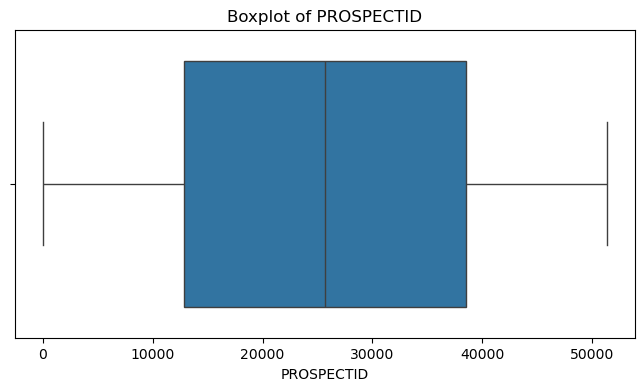

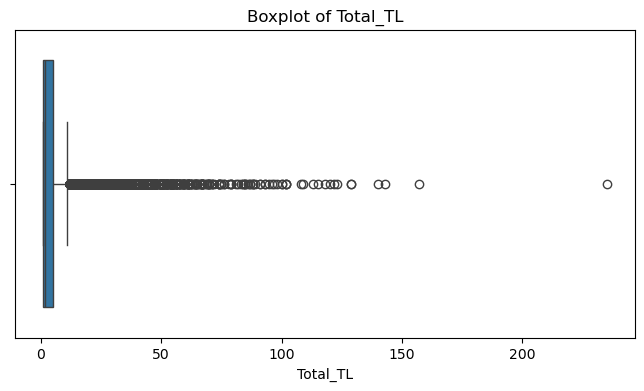

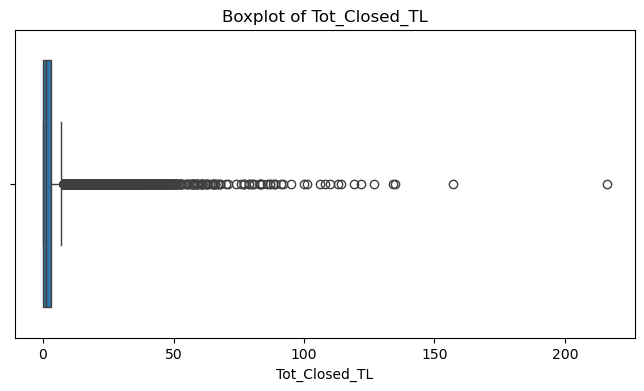

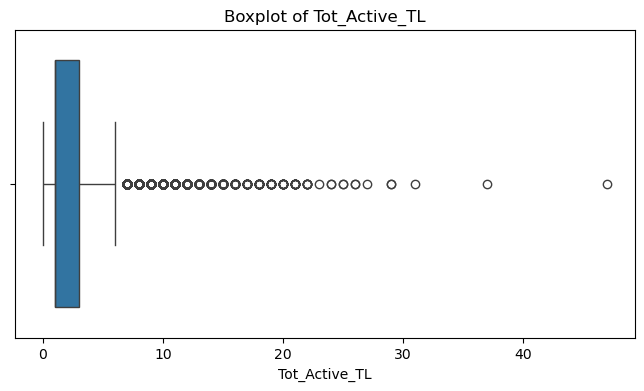

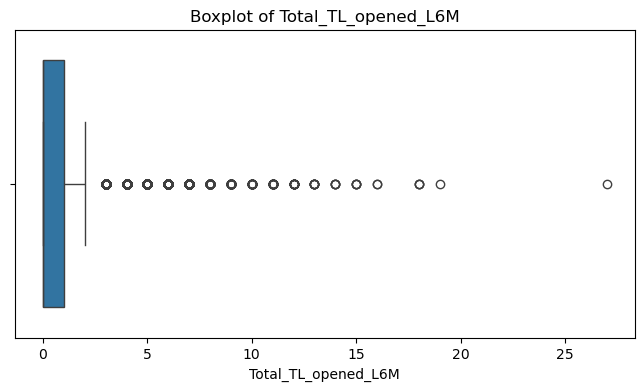

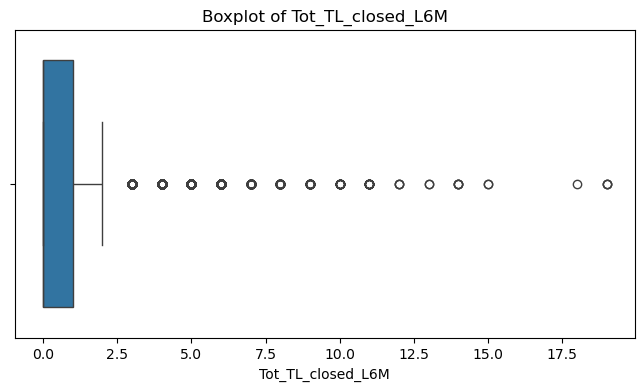

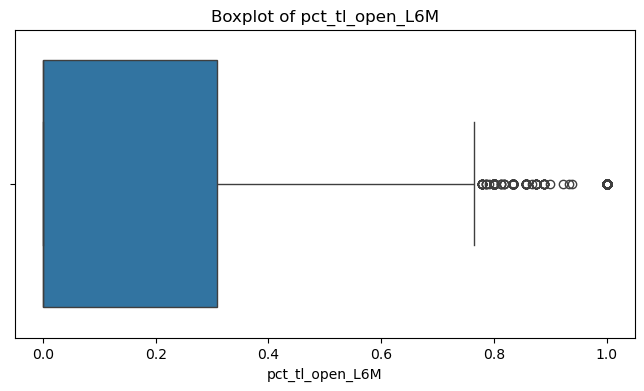

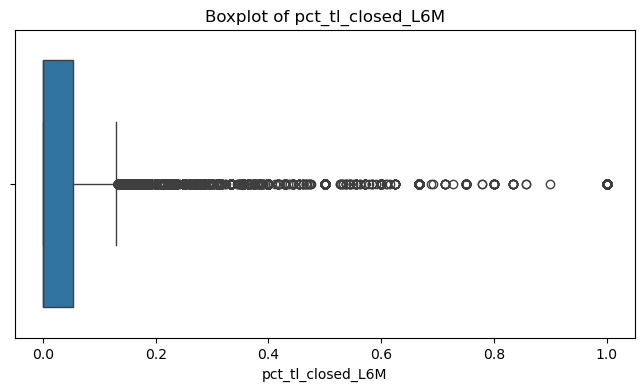

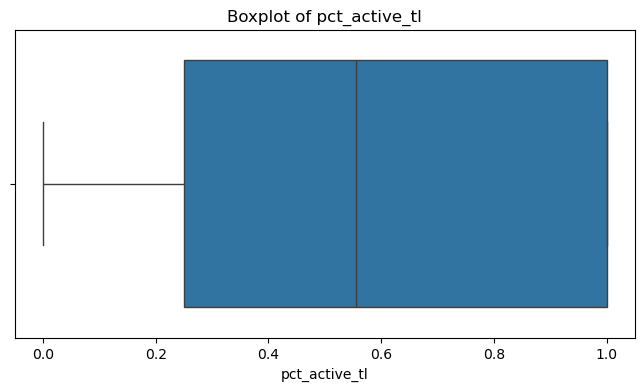

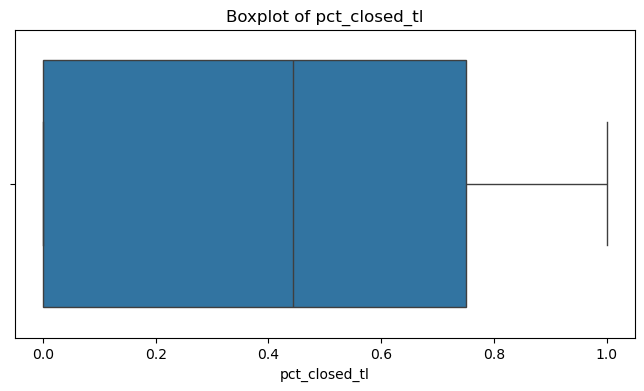

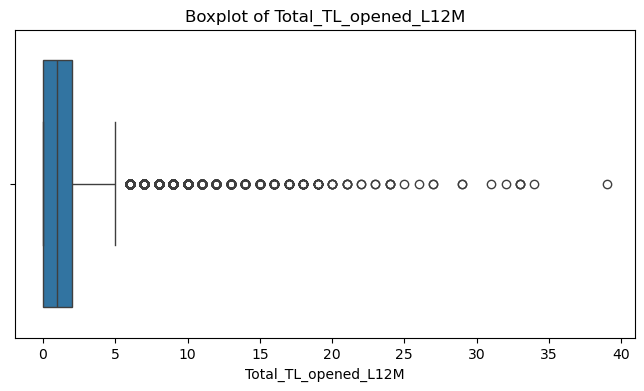

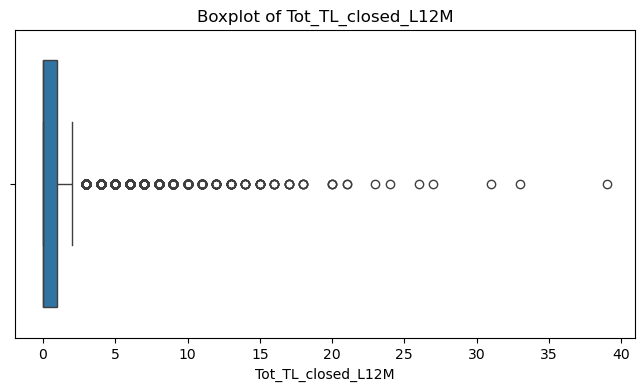

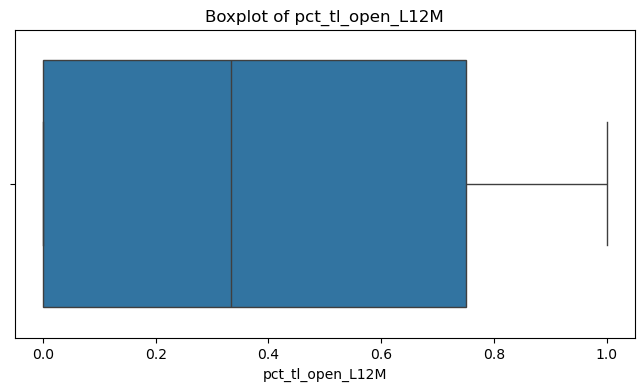

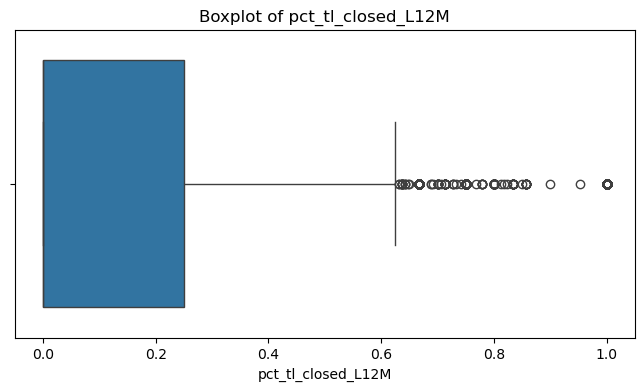

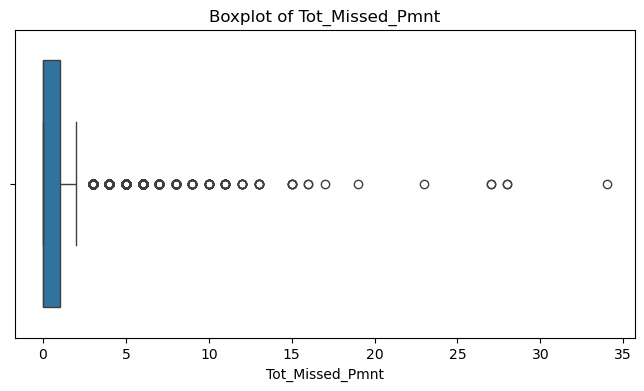

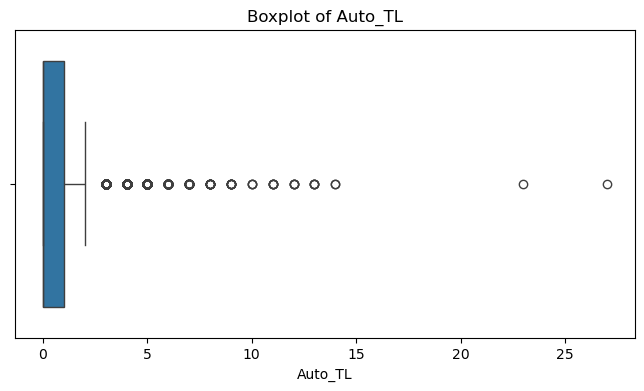

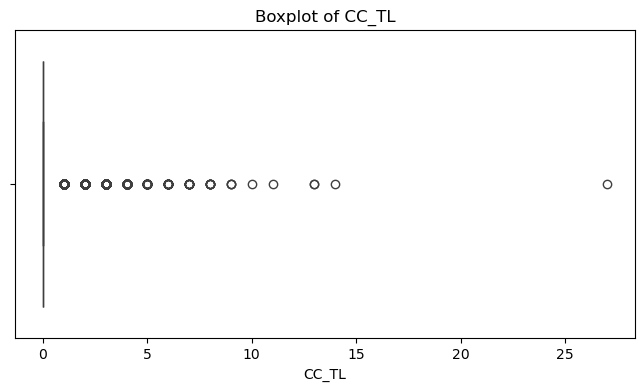

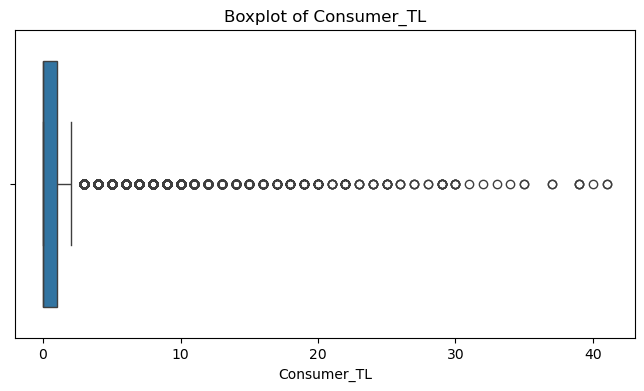

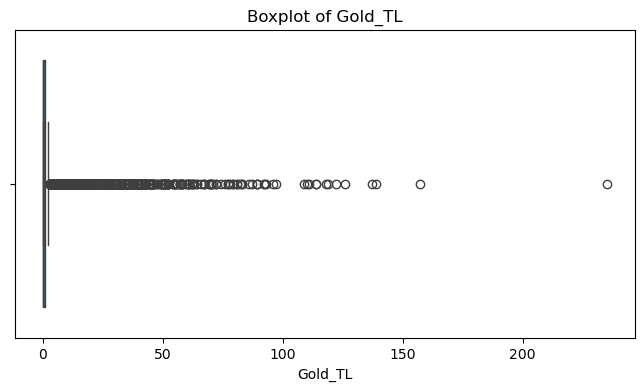

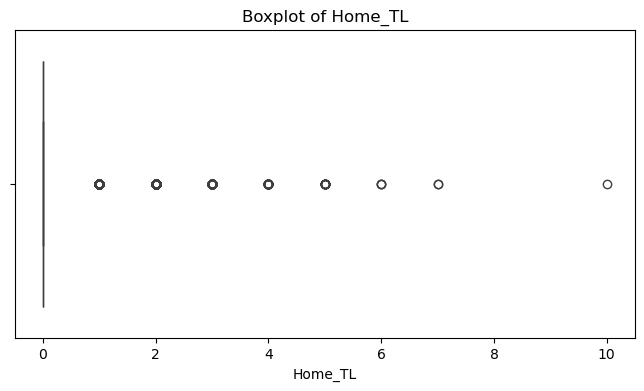

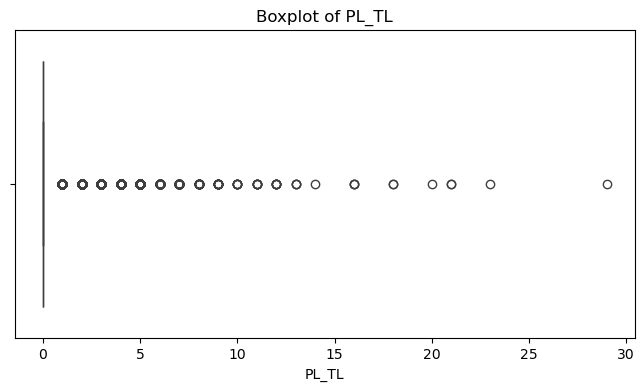

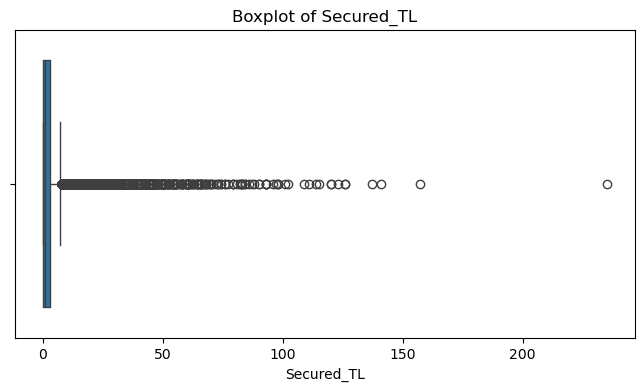

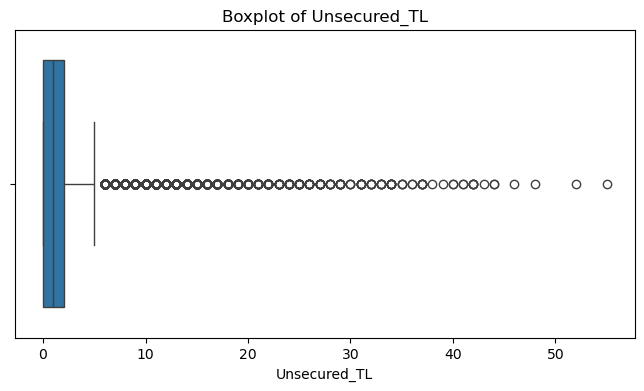

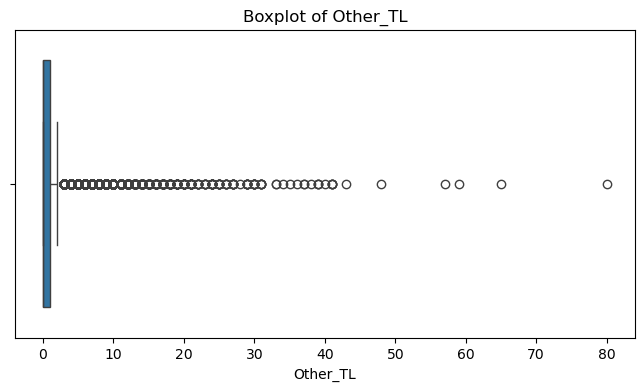

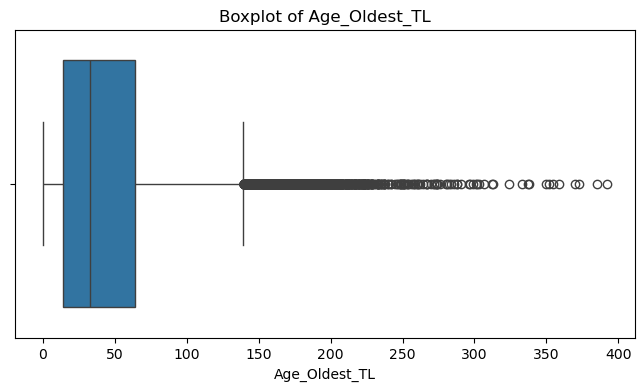

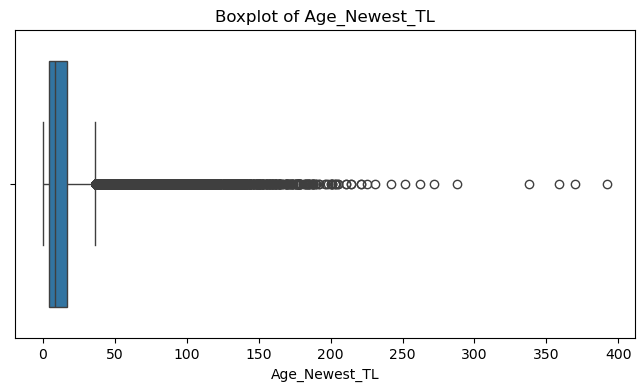

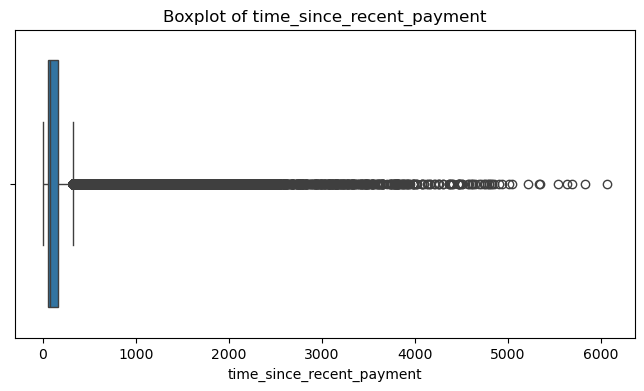

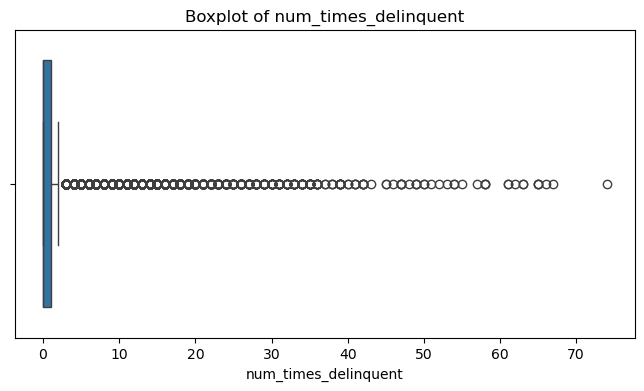

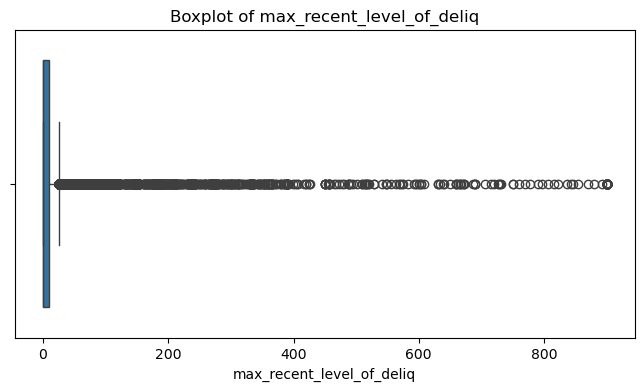

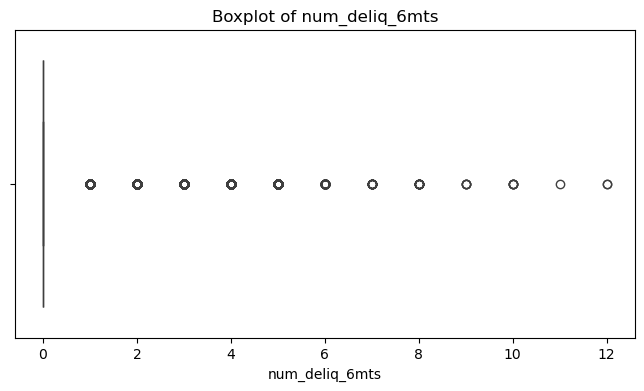

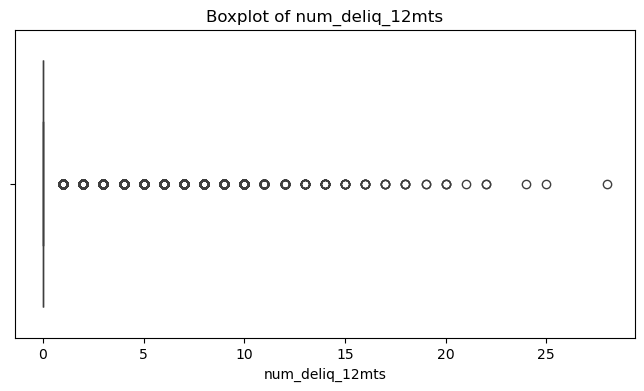

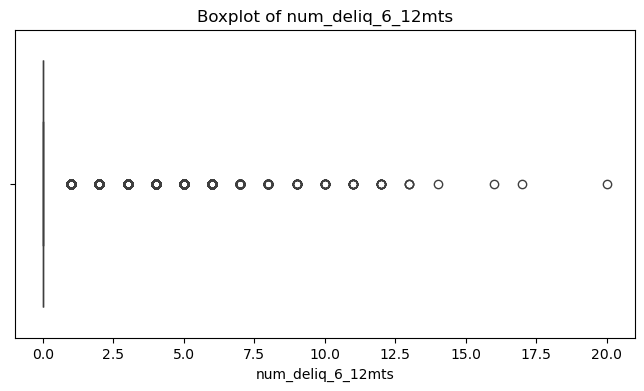

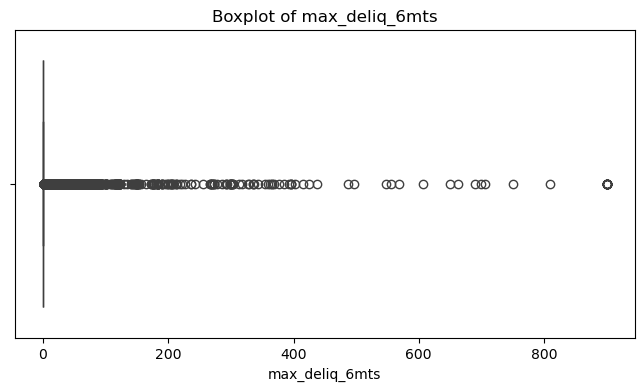

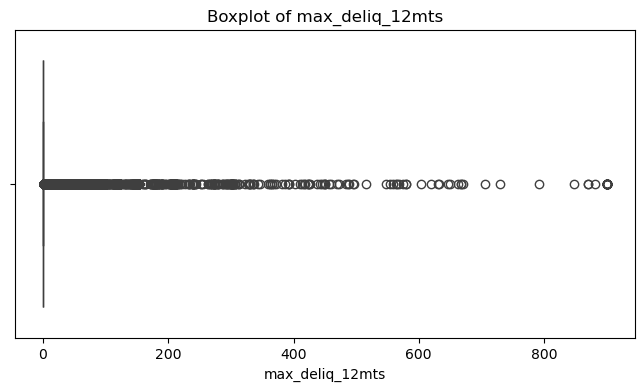

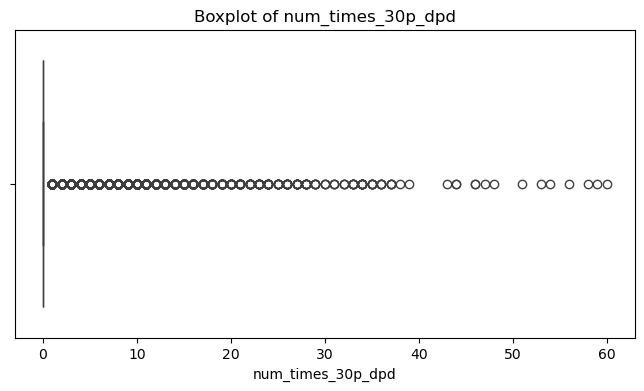

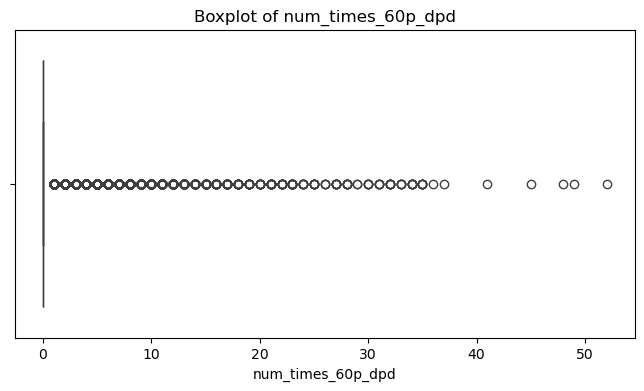

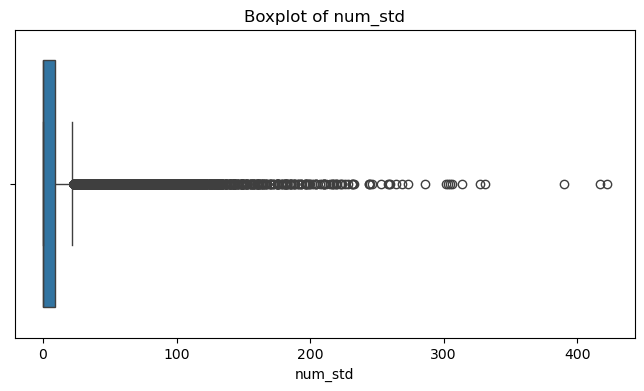

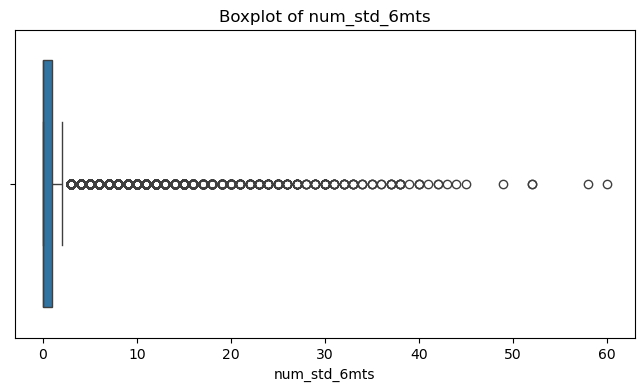

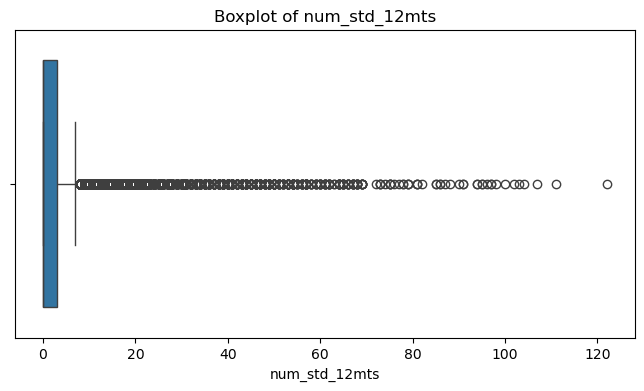

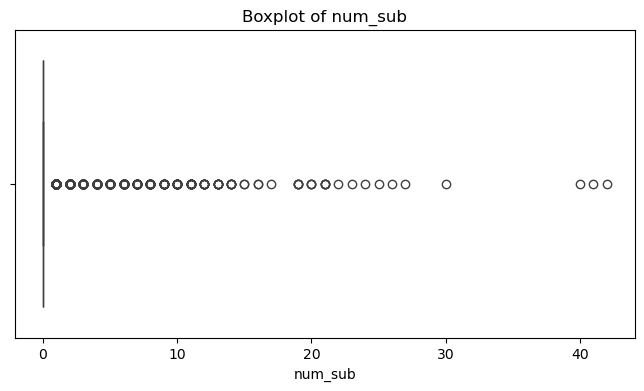

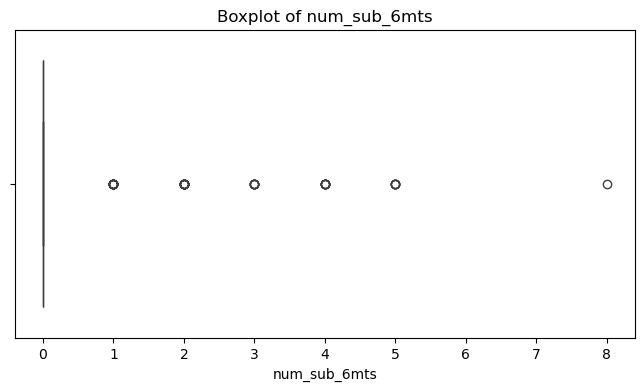

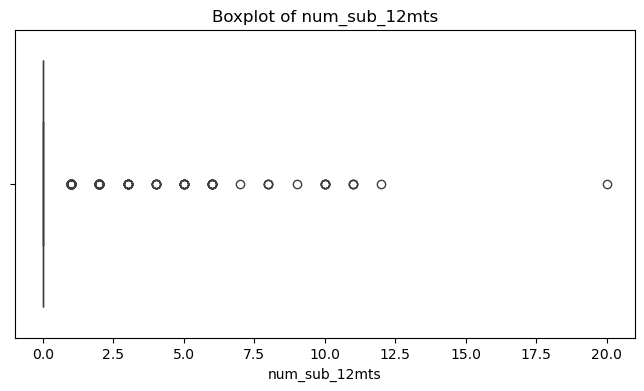

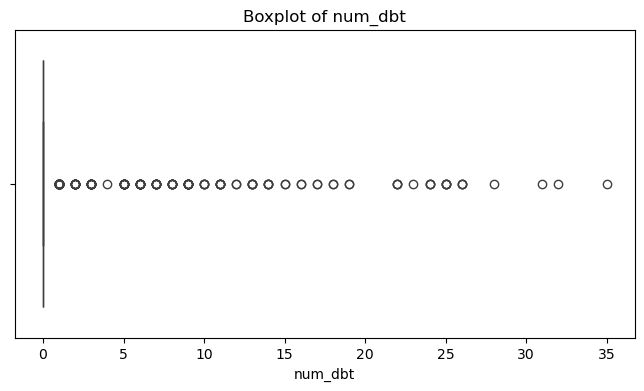

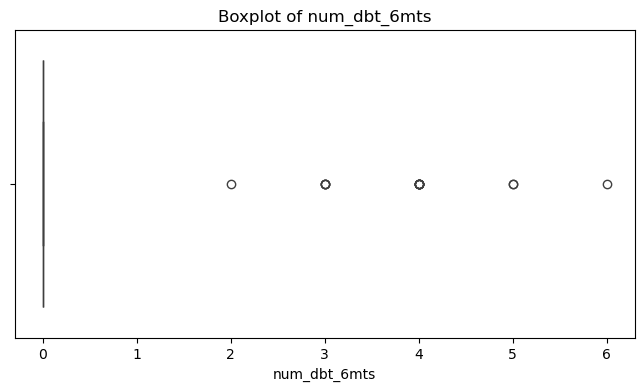

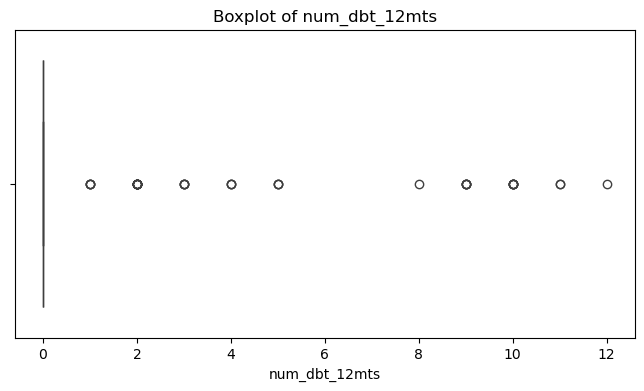

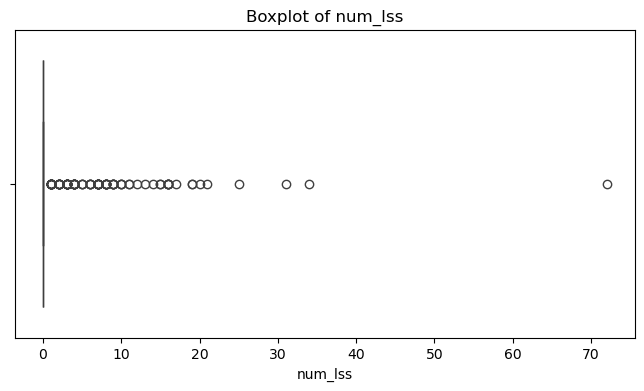

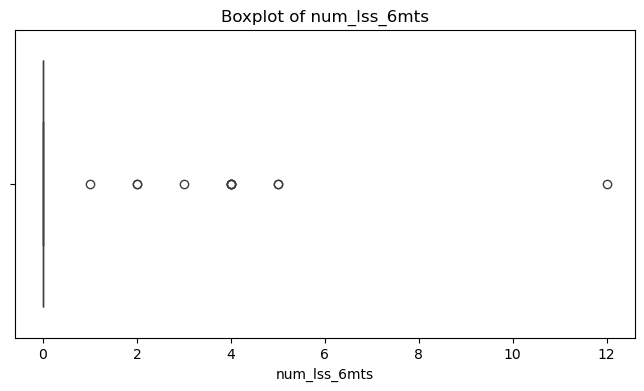

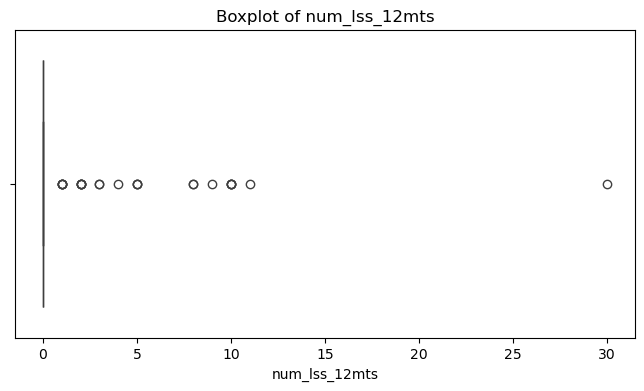

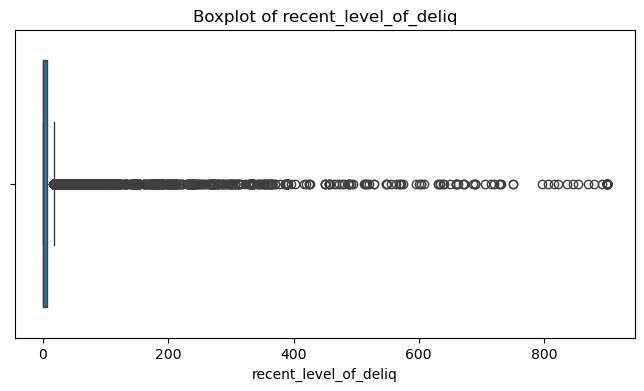

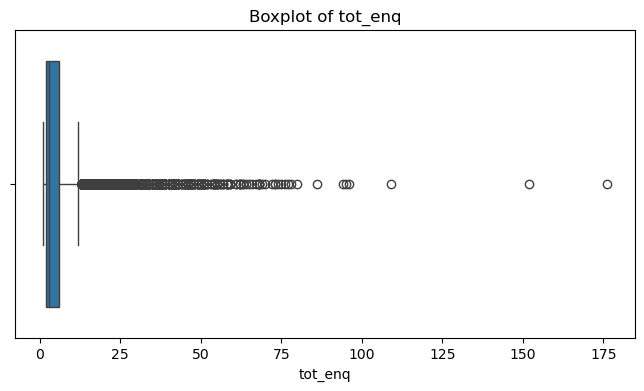

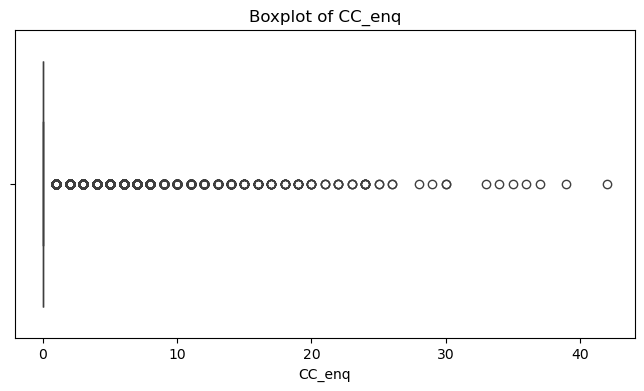

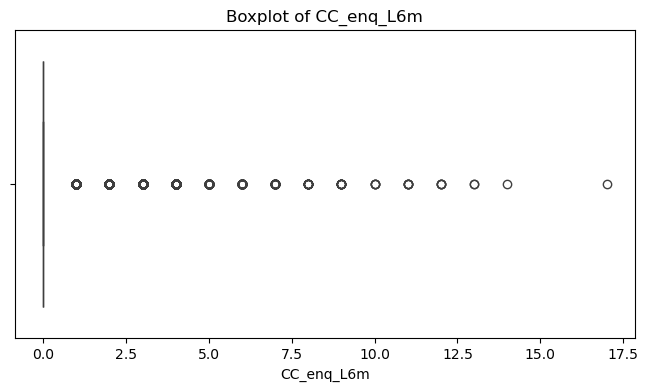

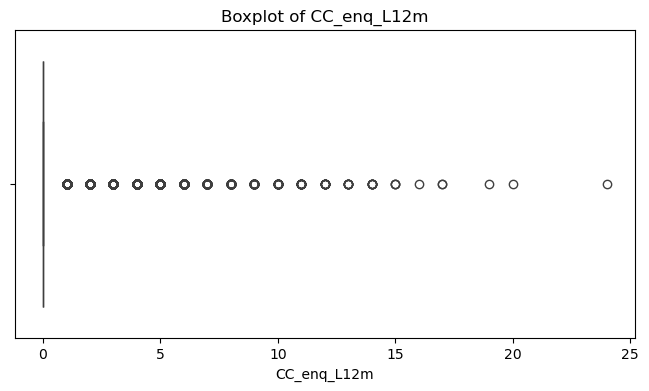

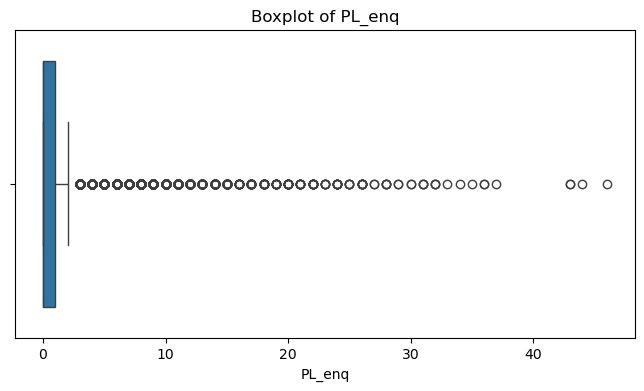

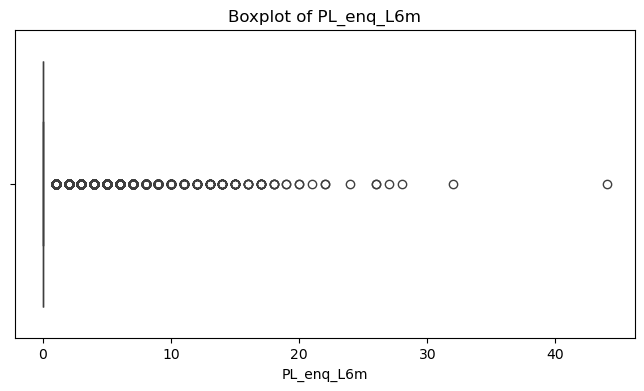

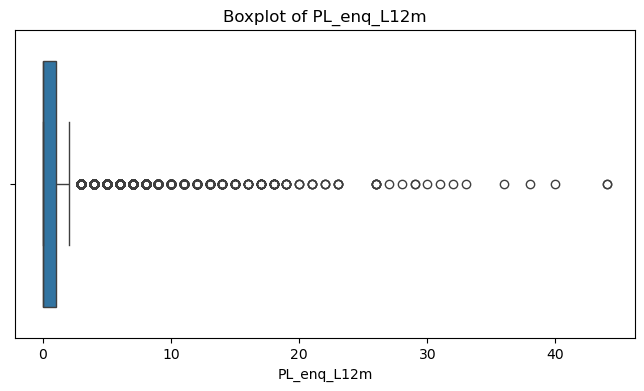

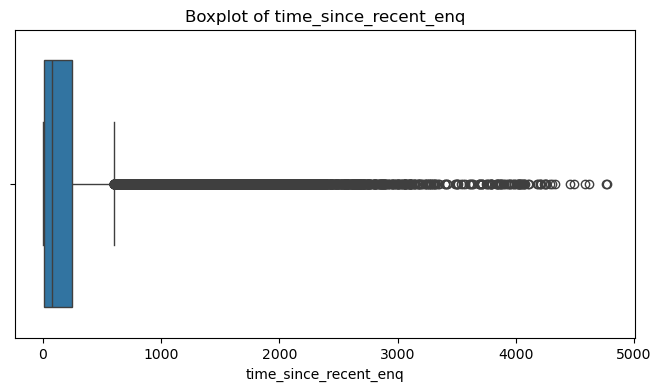

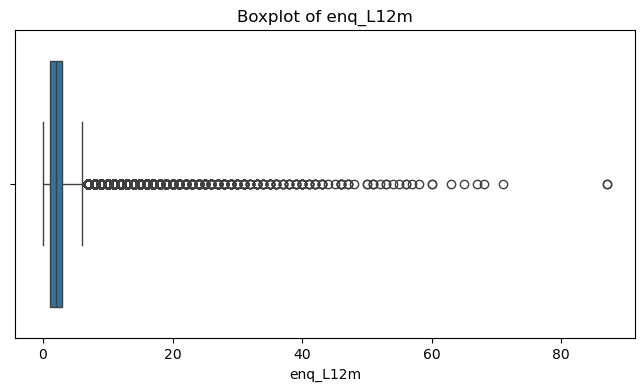

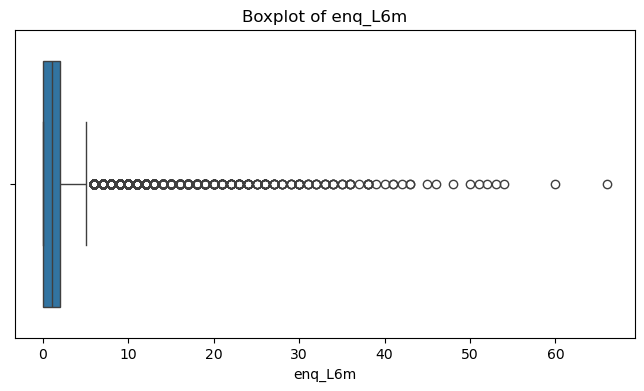

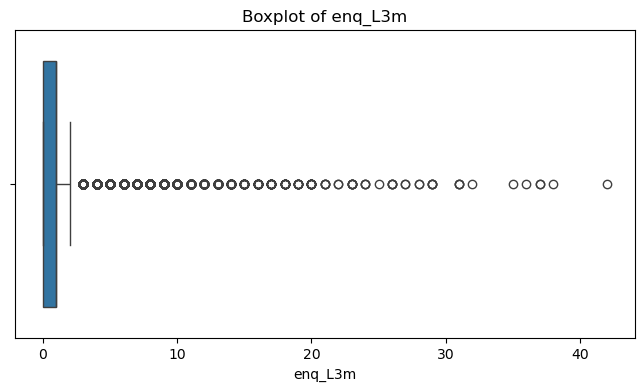

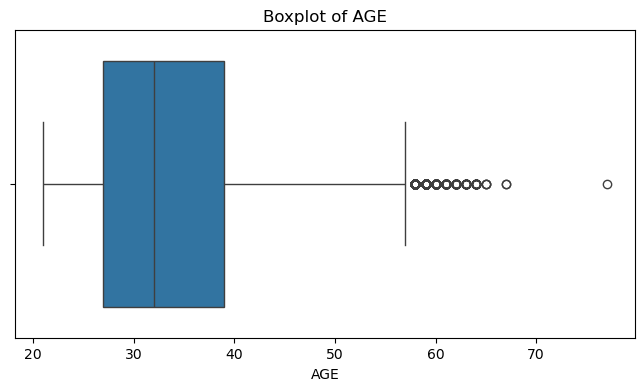

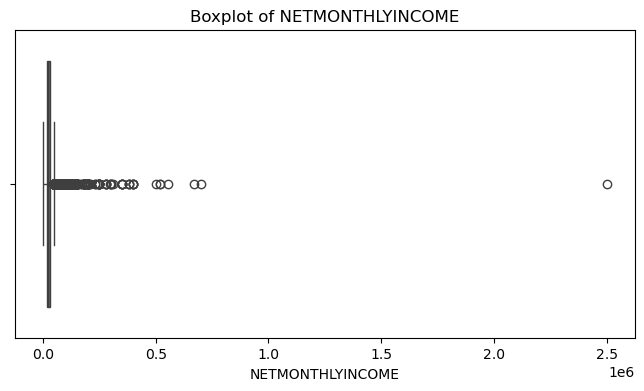

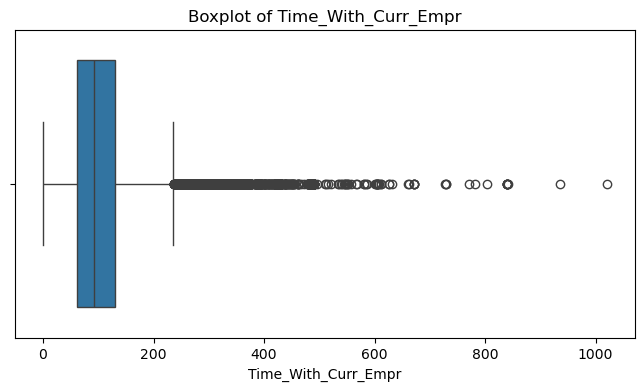

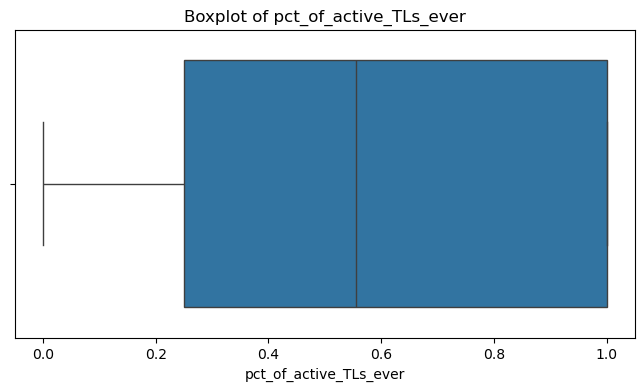

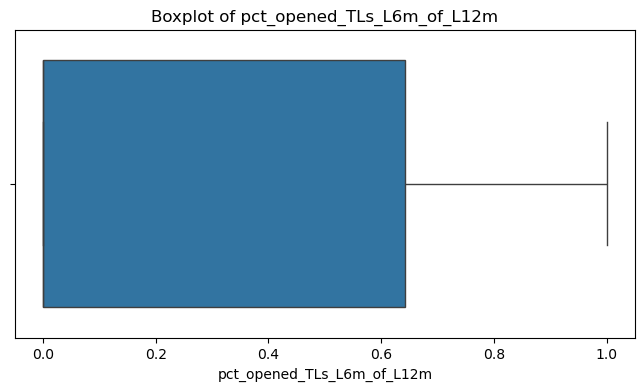

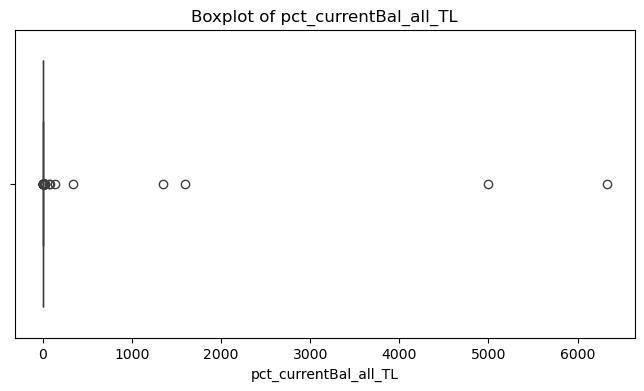

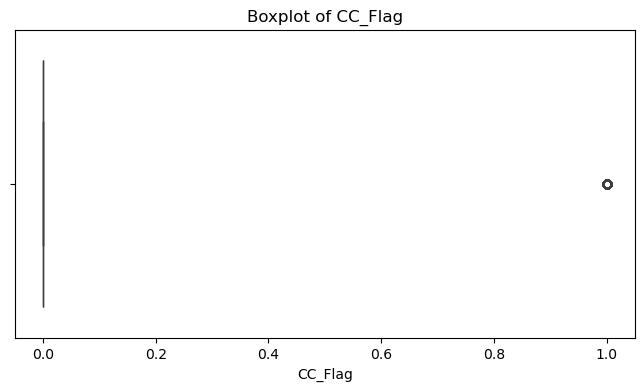

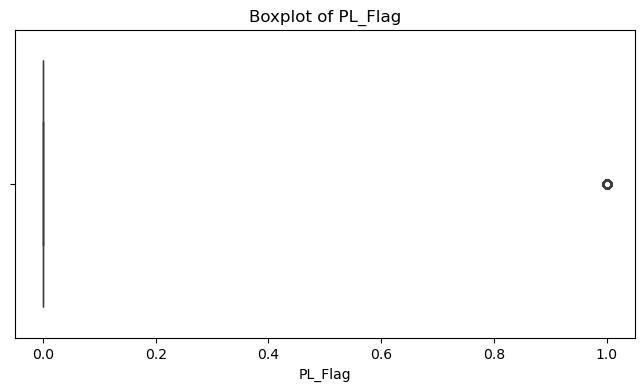

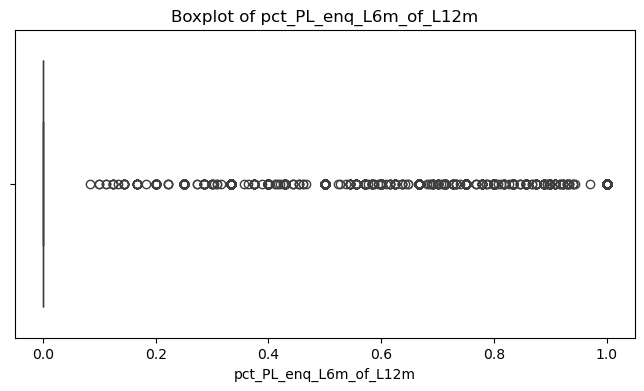

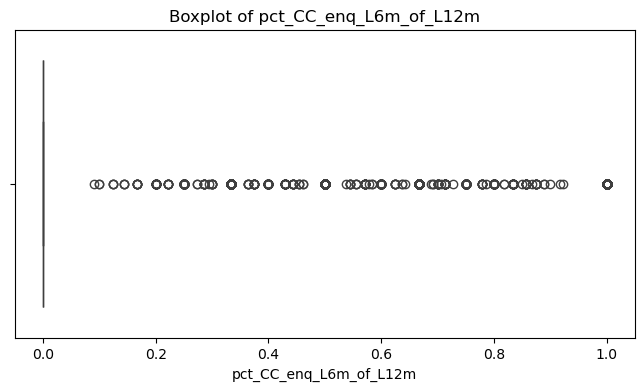

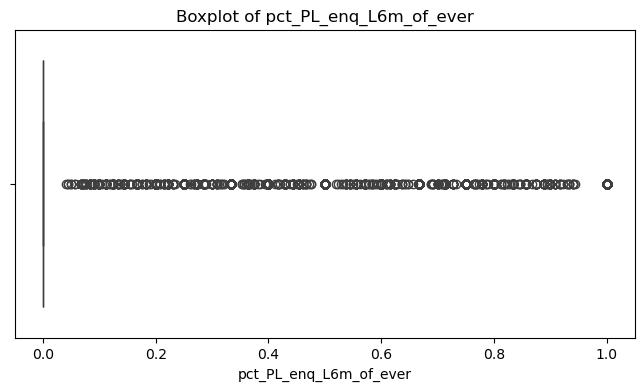

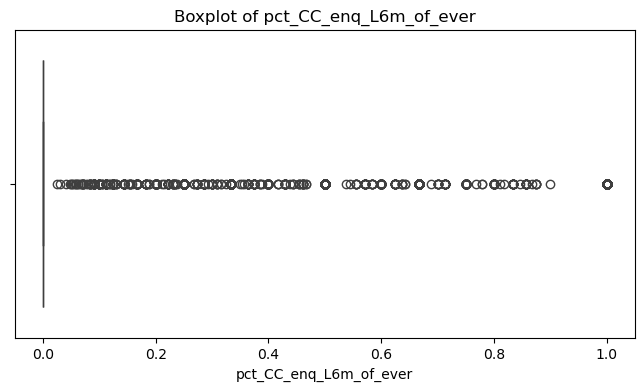

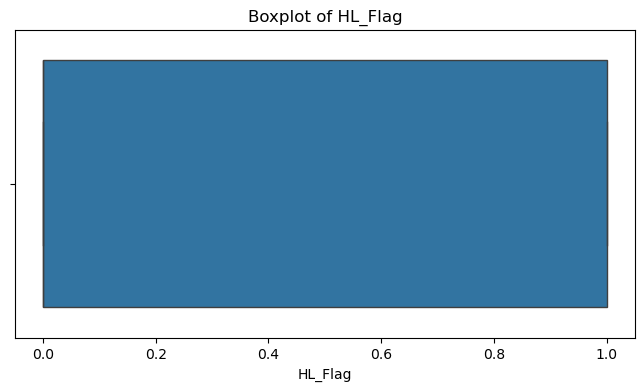

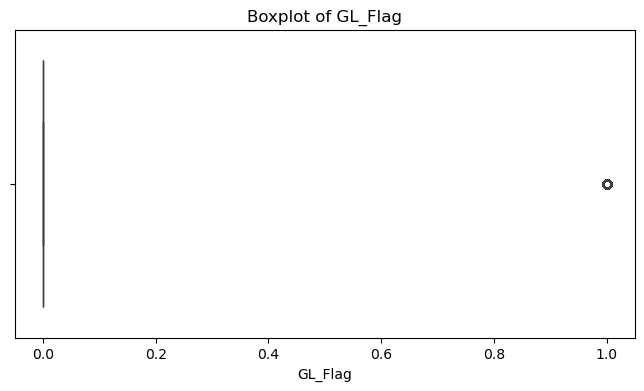

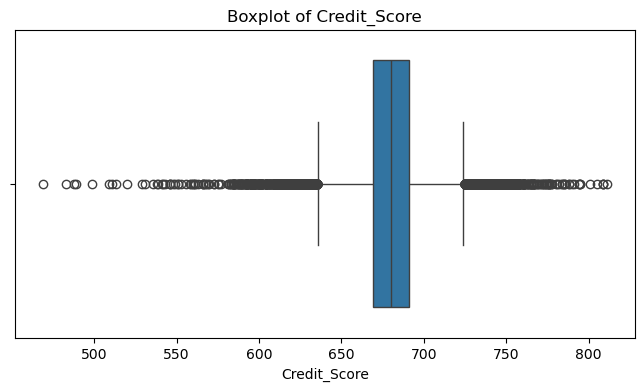

In [124]:
# Check the outliers
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [34]:
# Treat the Outliers
def outliers(x):
    if ((x.dtype == int) or (x.dtype == float)): 
        x = x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99))
    return x

In [36]:
df  = df.apply(lambda x: outliers(x))

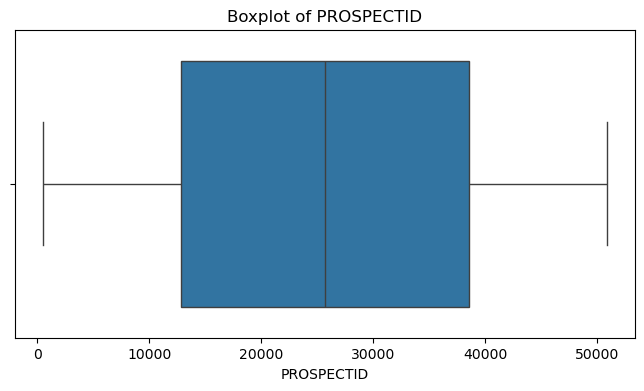

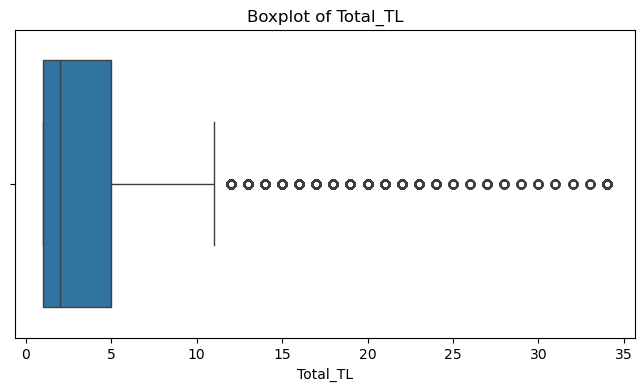

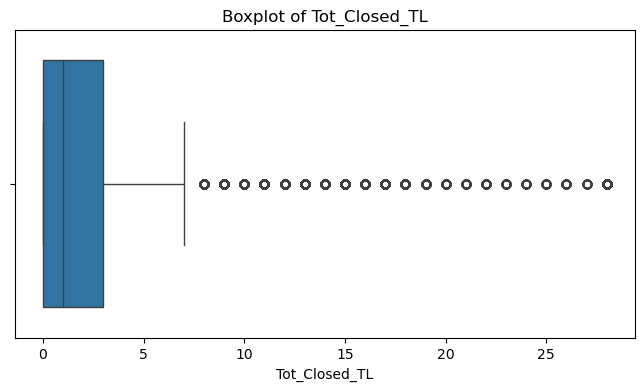

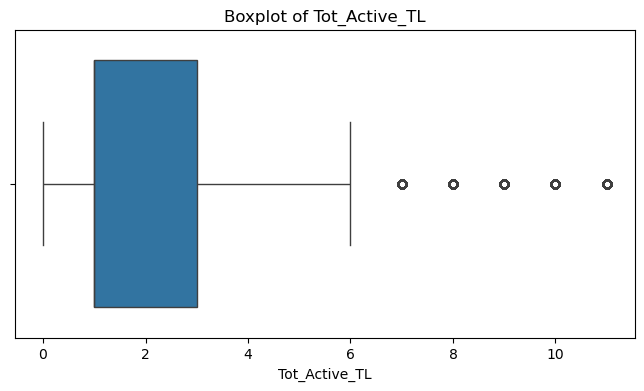

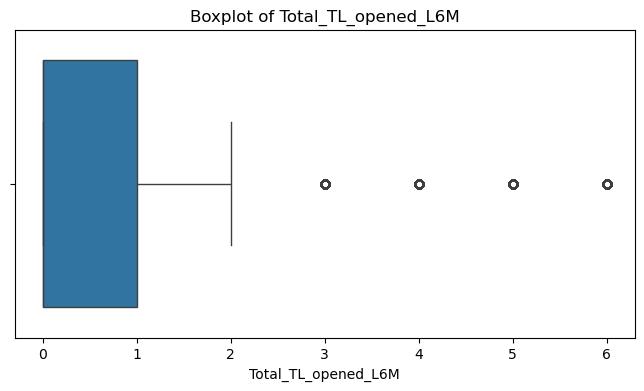

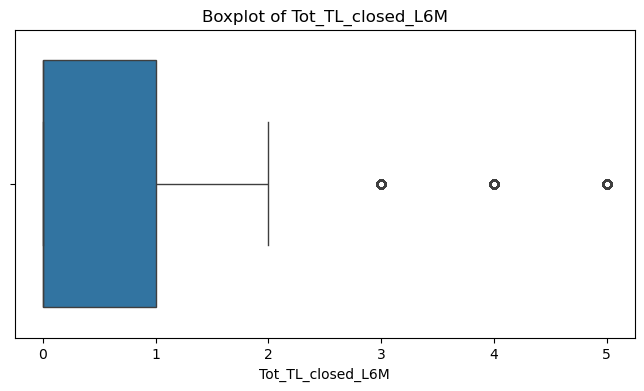

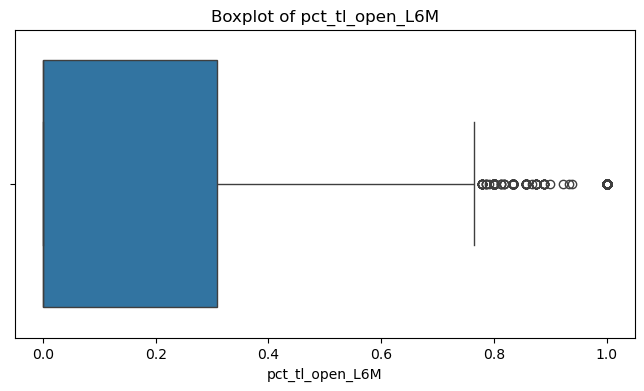

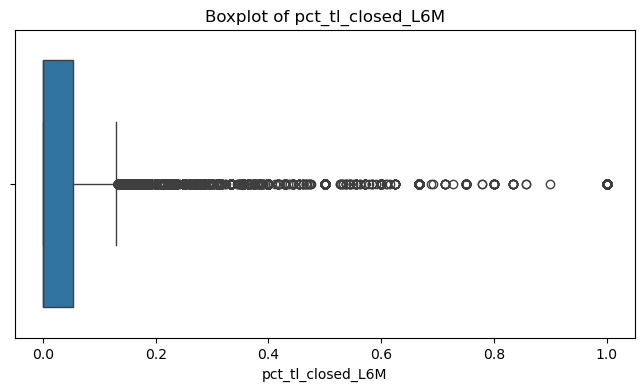

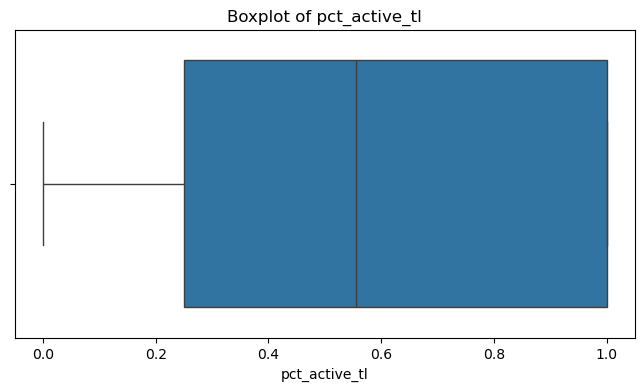

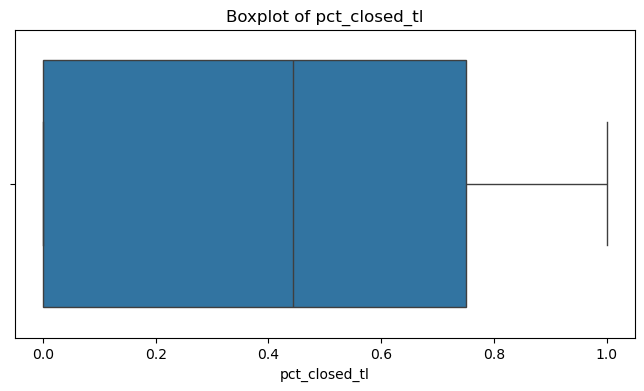

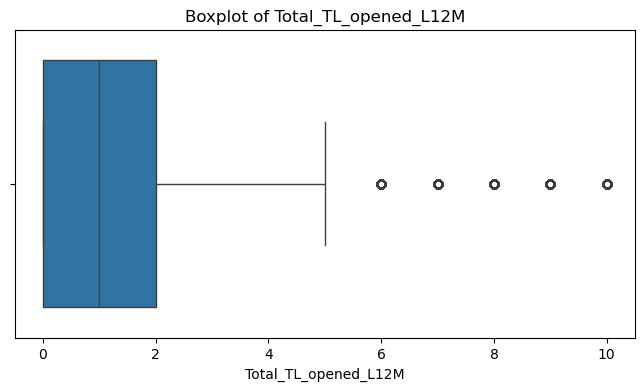

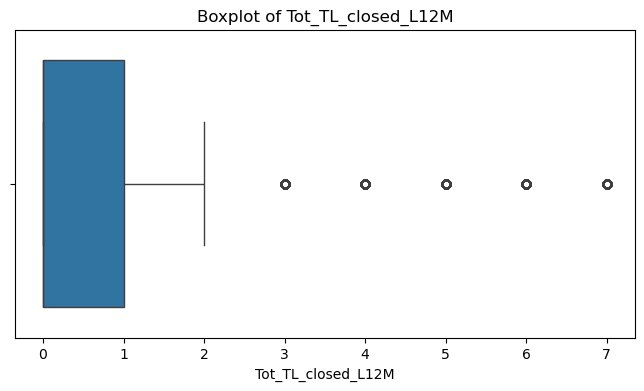

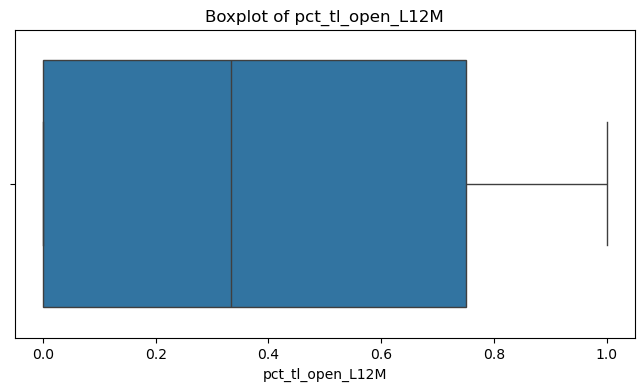

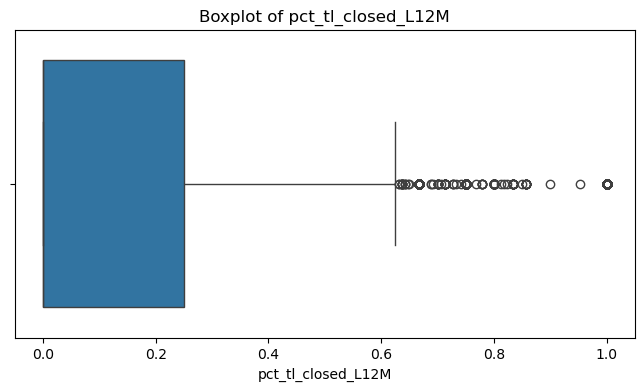

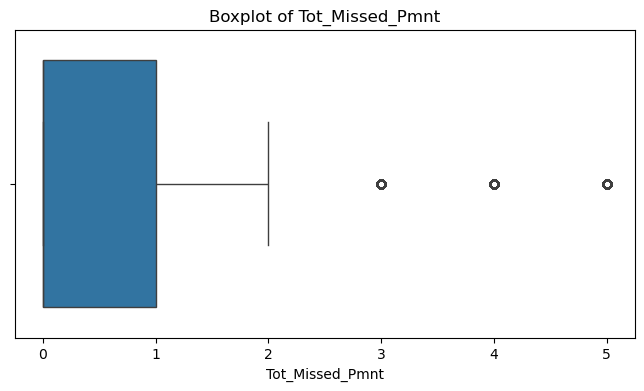

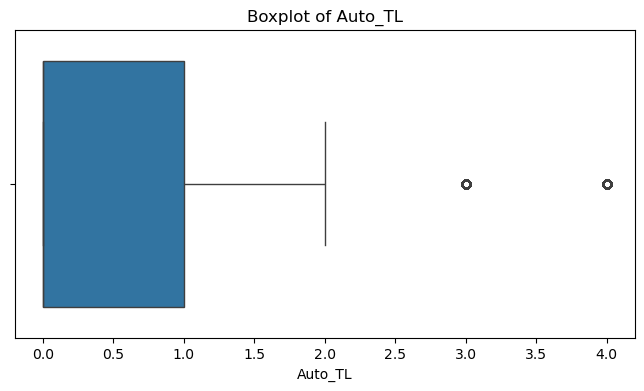

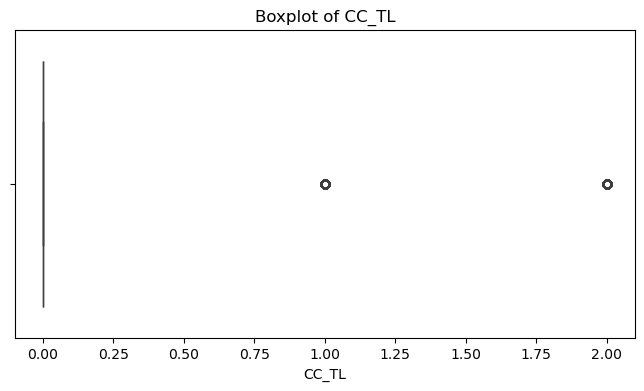

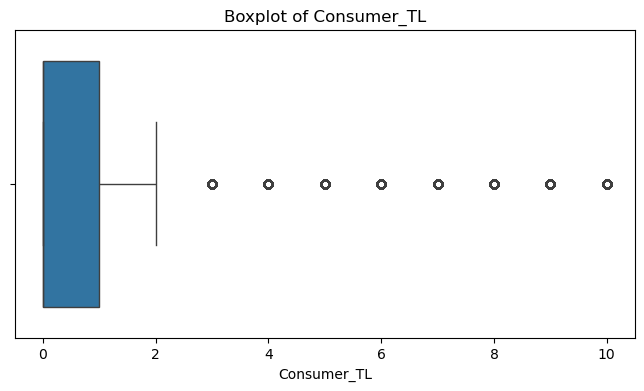

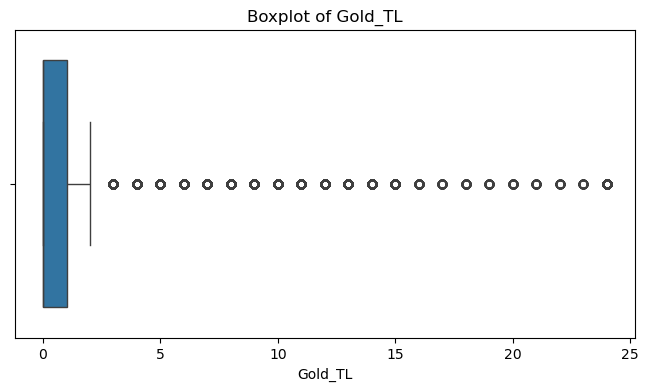

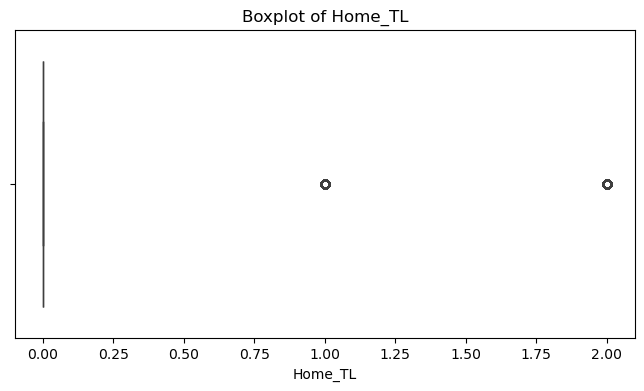

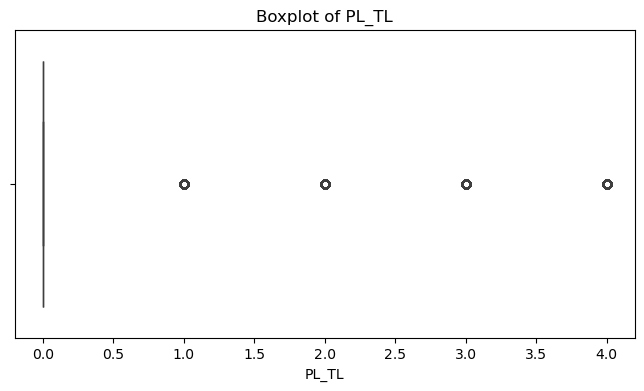

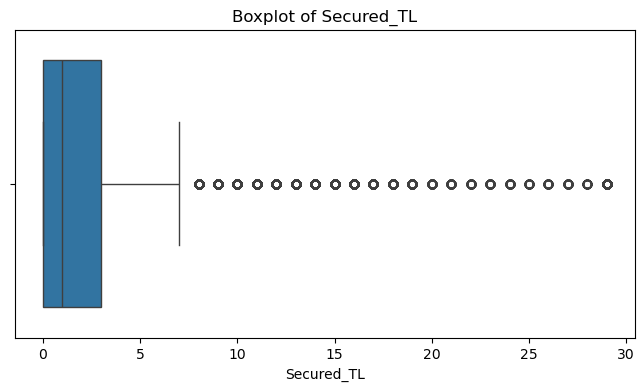

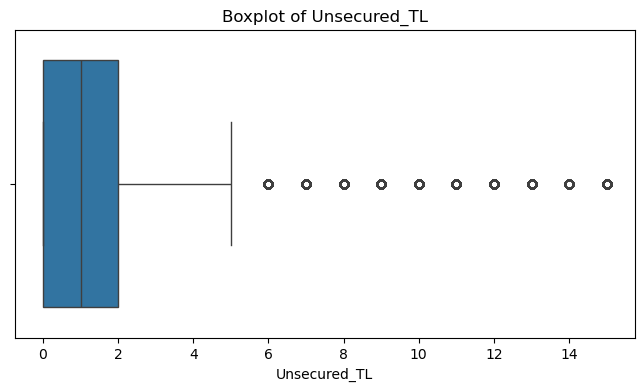

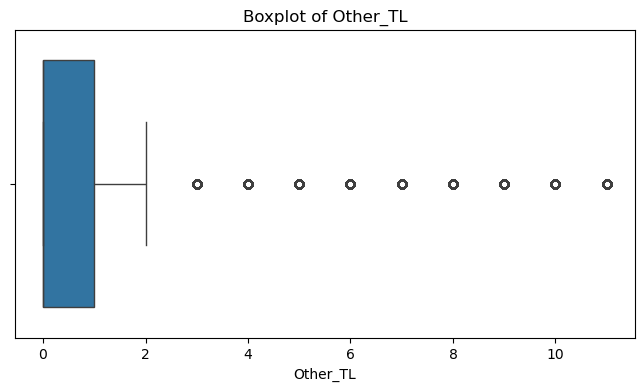

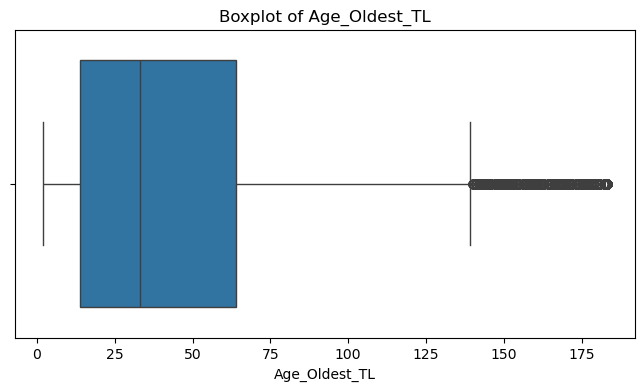

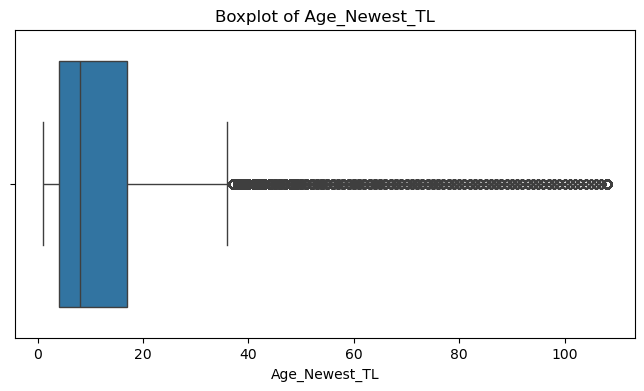

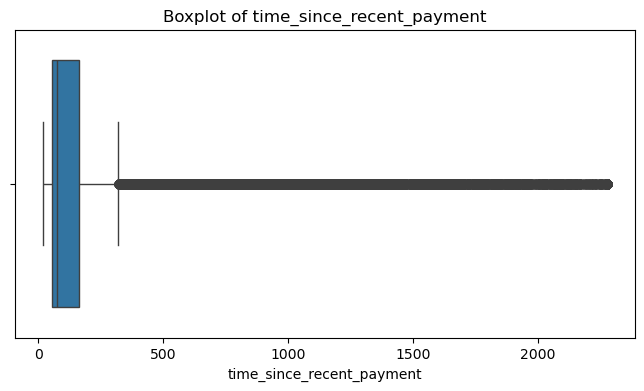

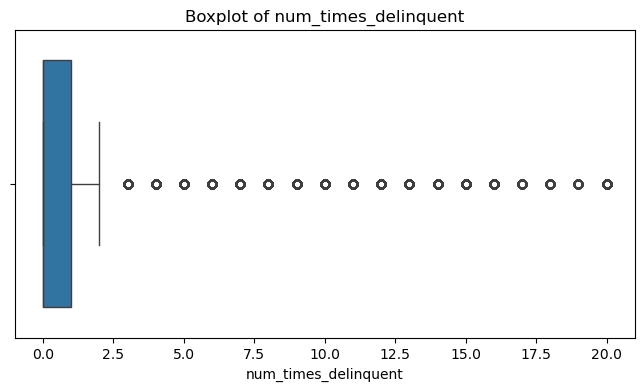

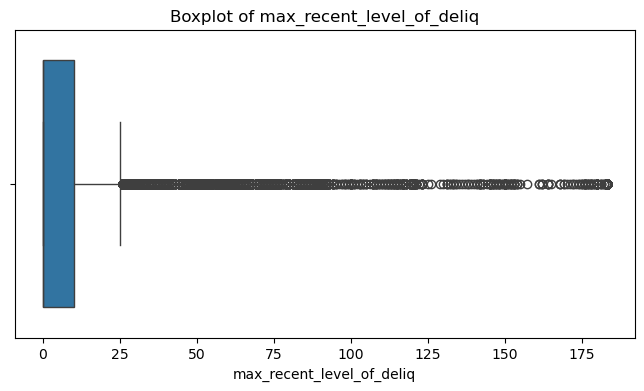

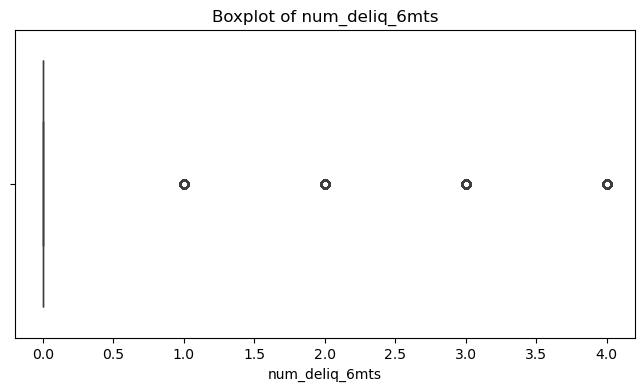

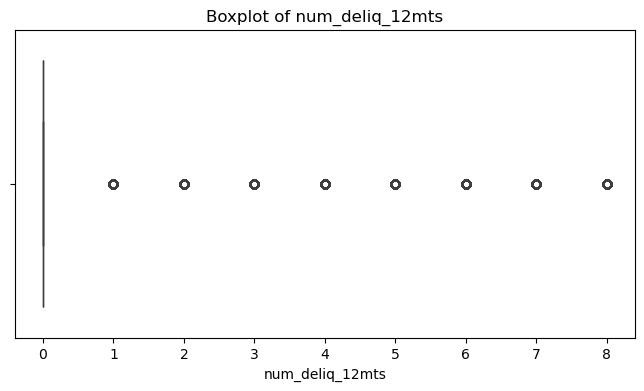

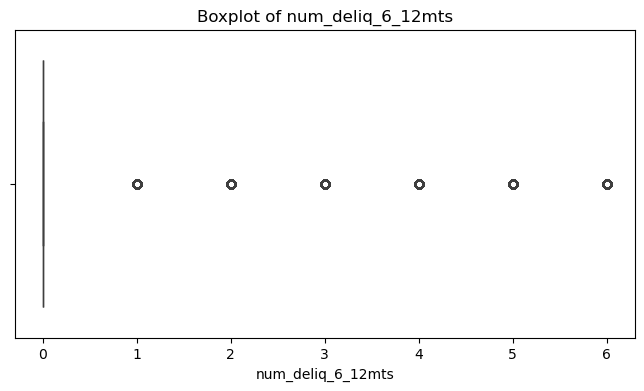

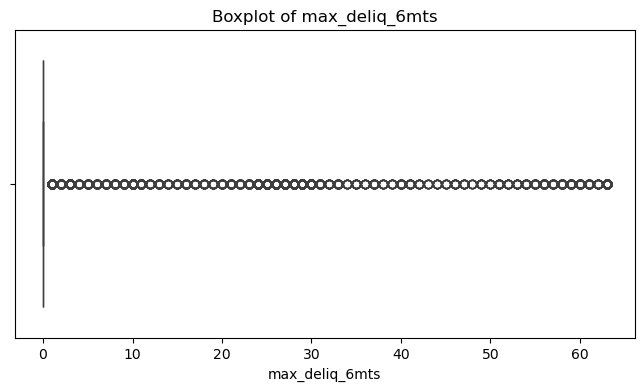

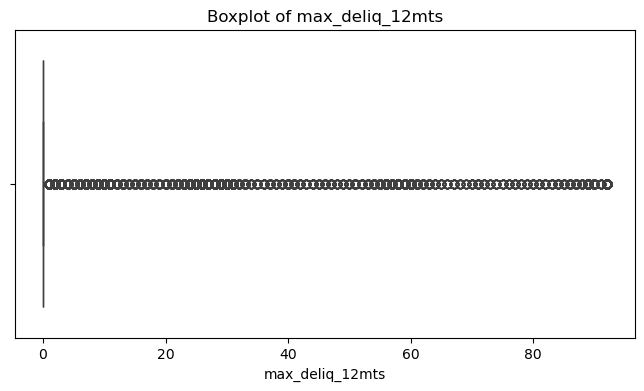

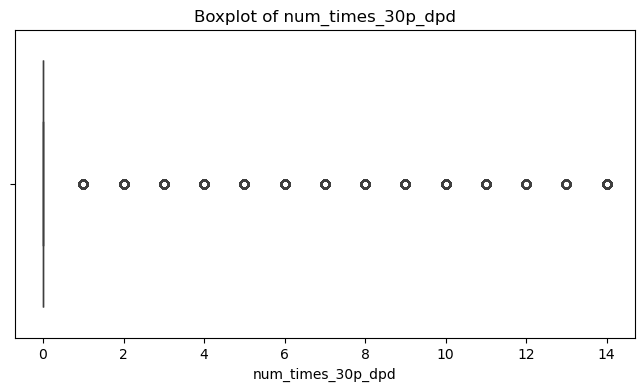

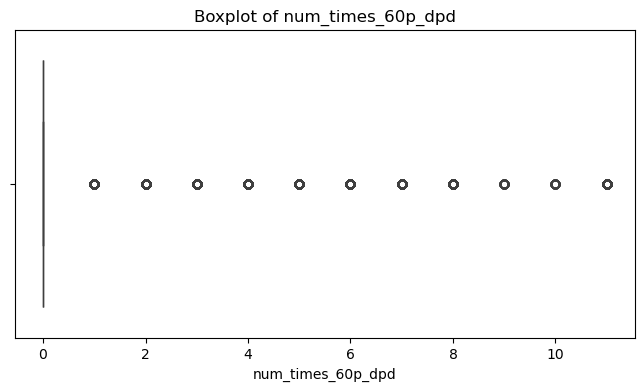

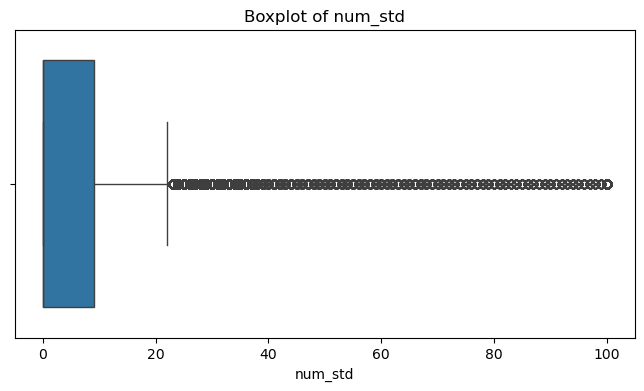

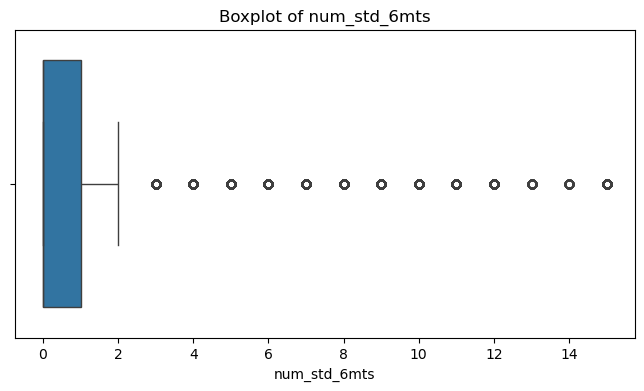

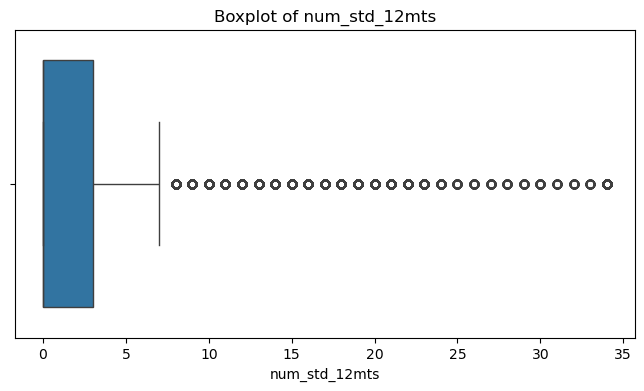

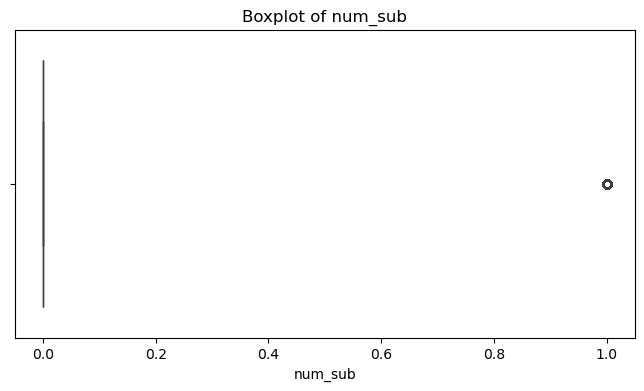

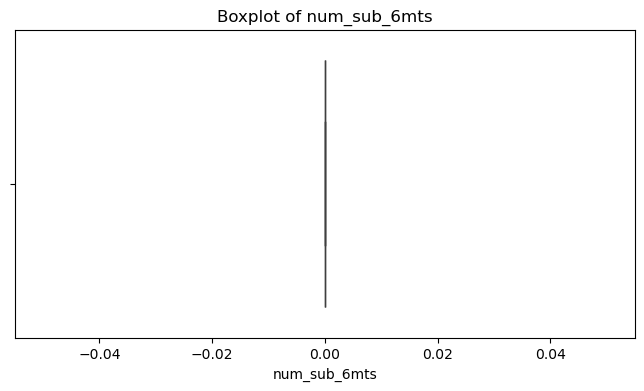

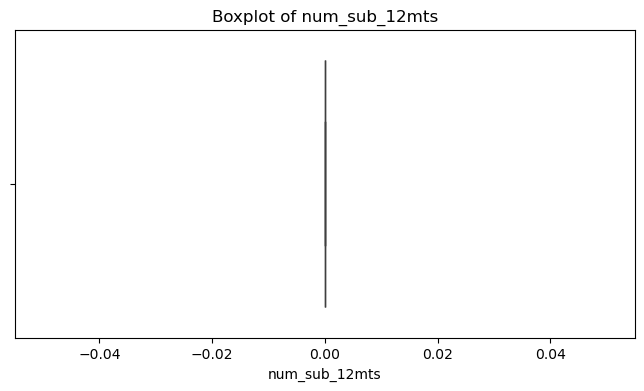

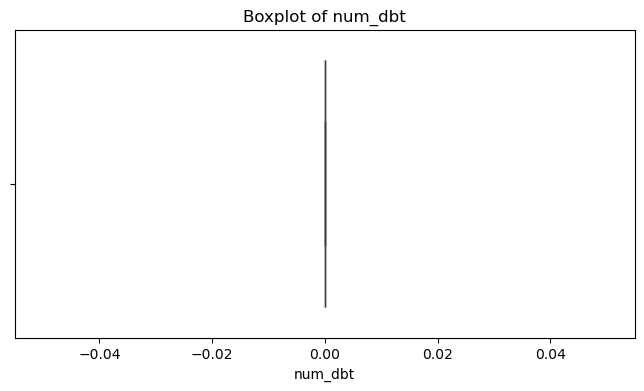

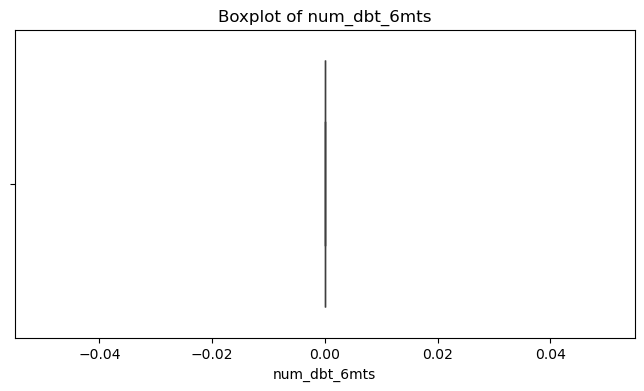

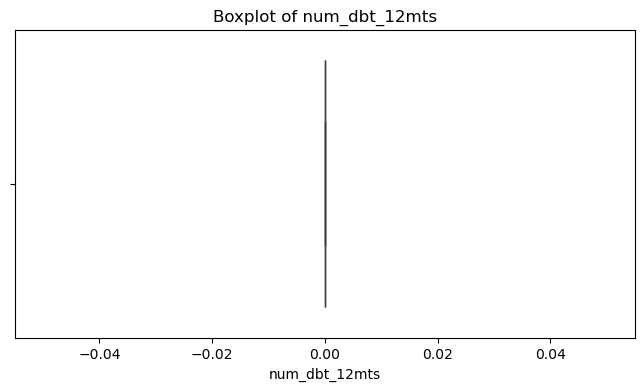

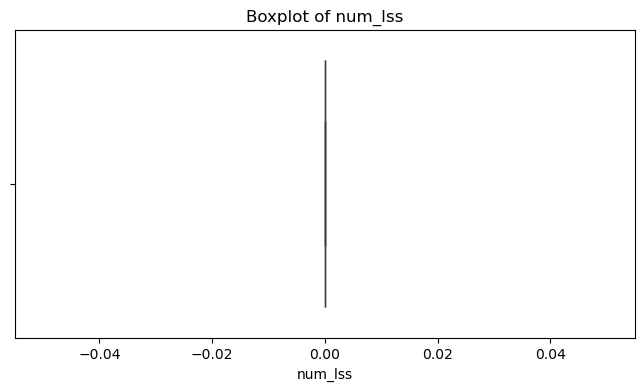

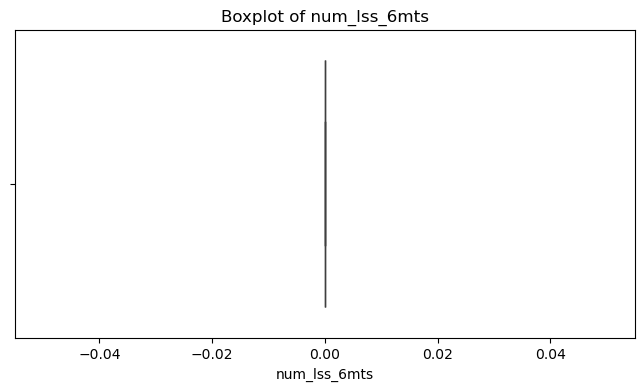

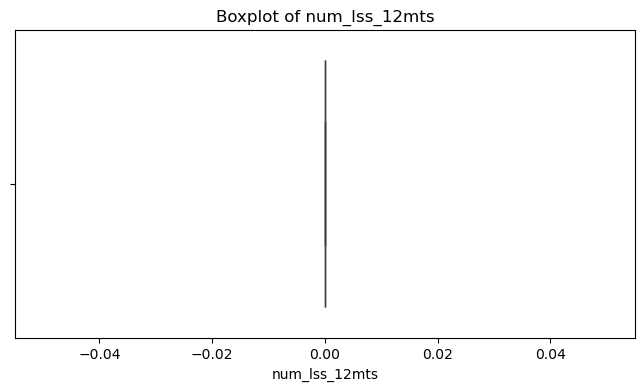

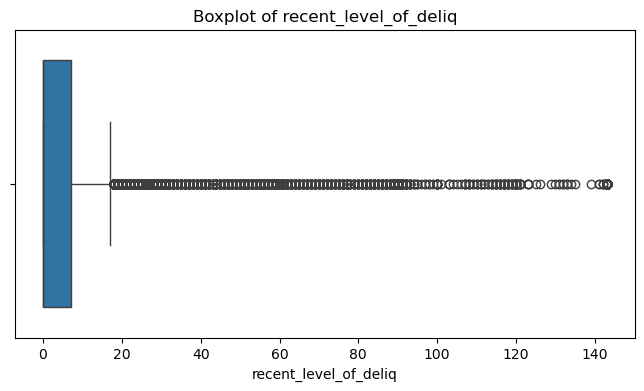

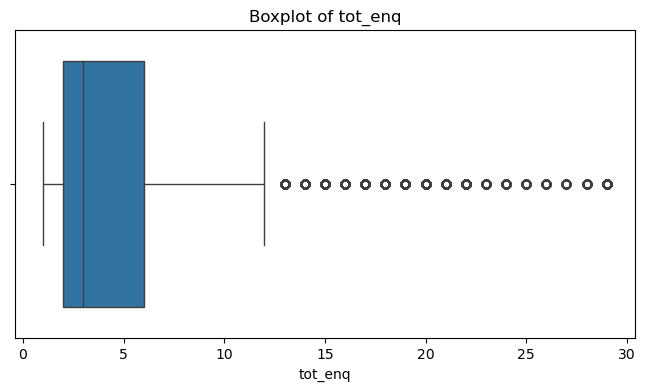

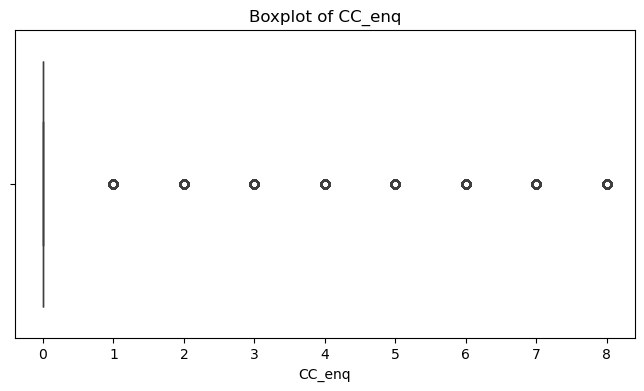

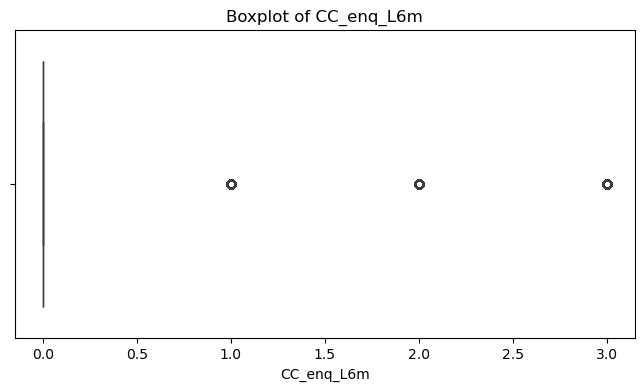

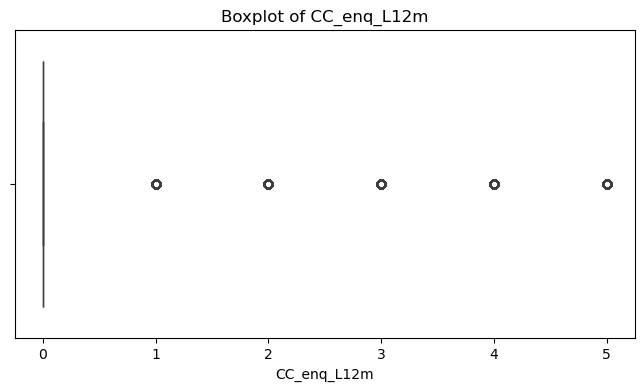

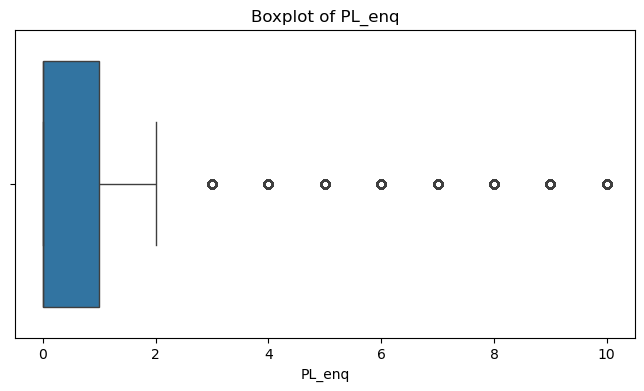

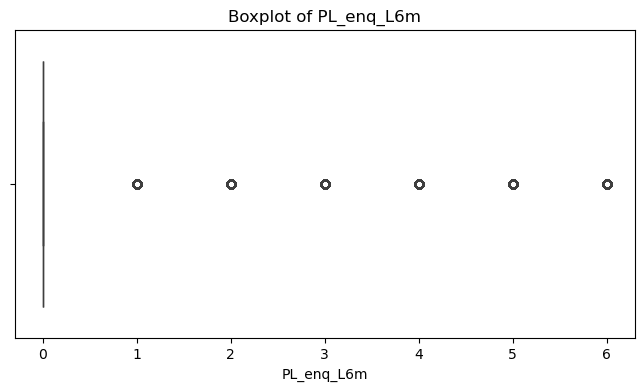

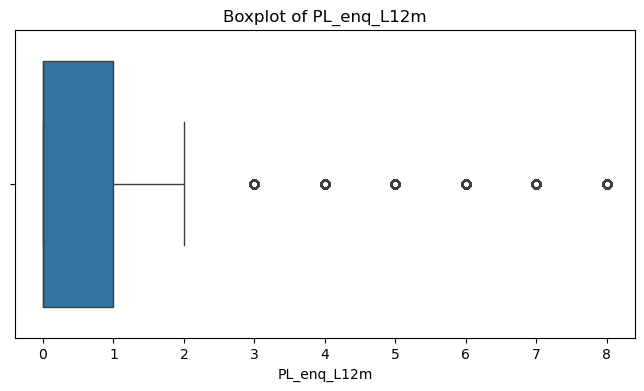

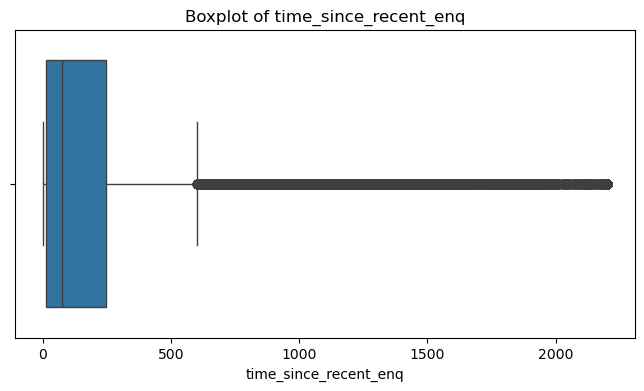

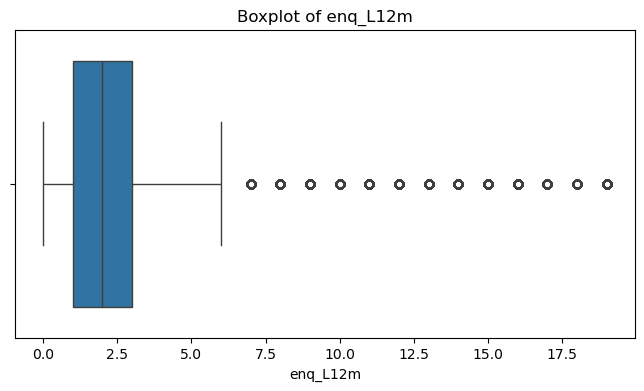

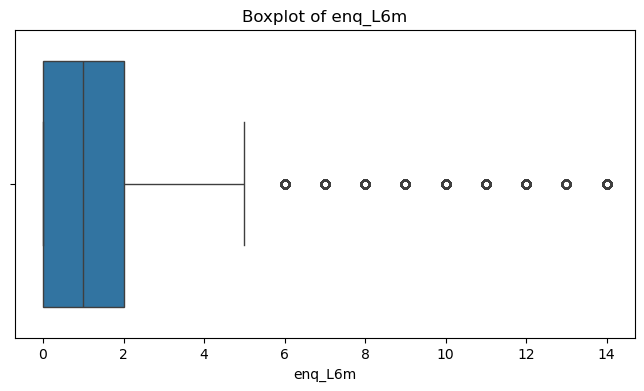

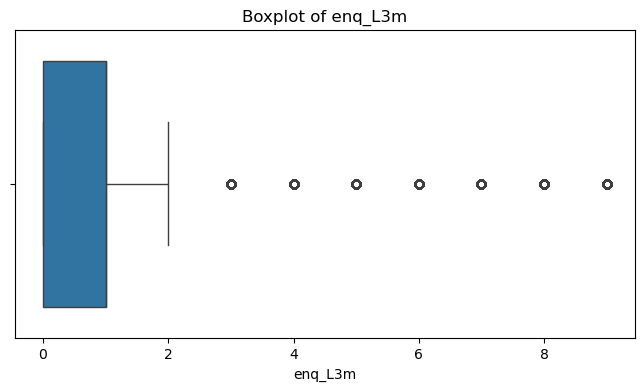

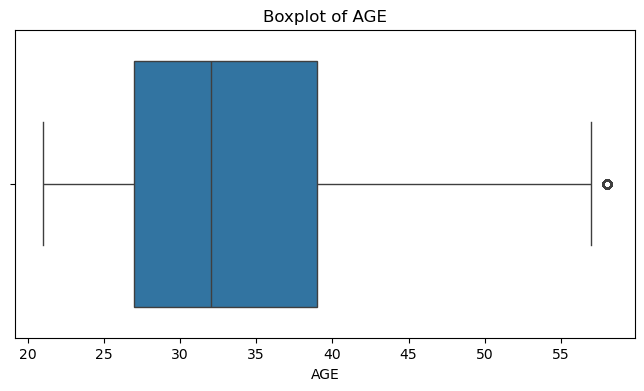

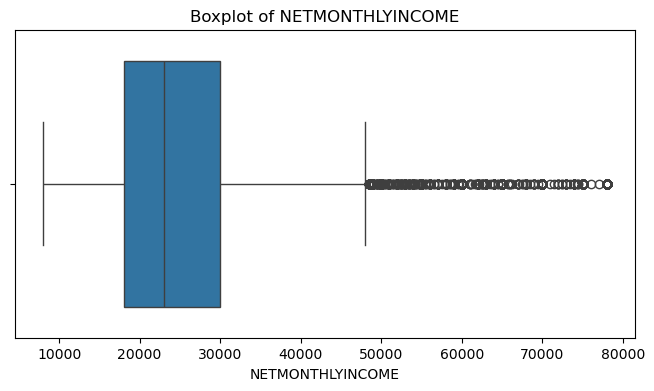

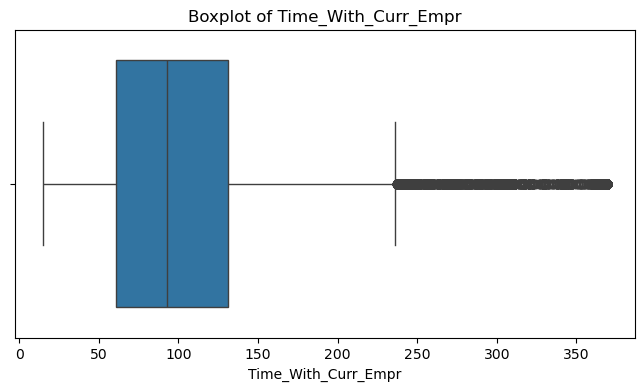

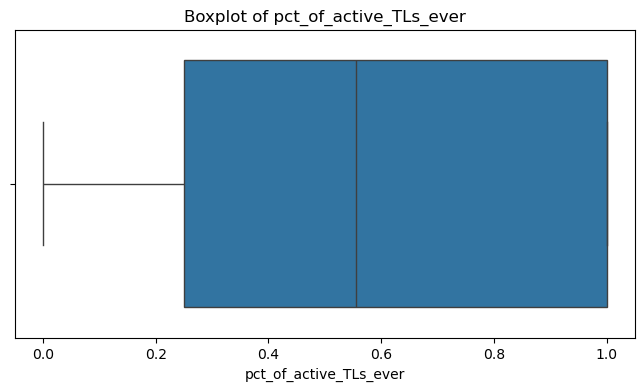

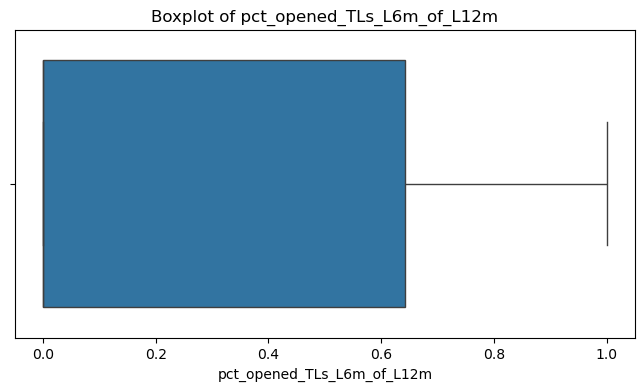

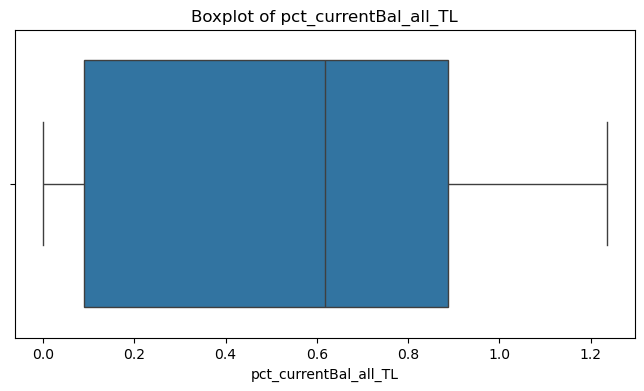

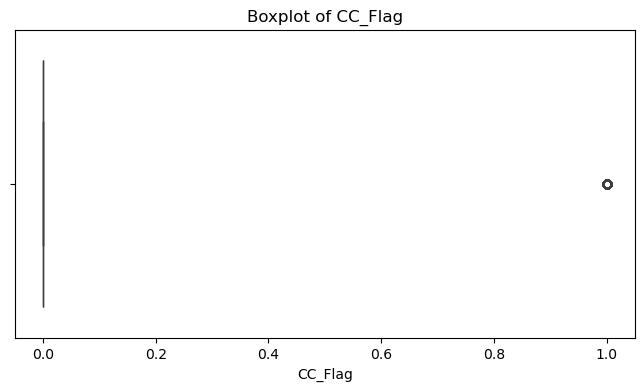

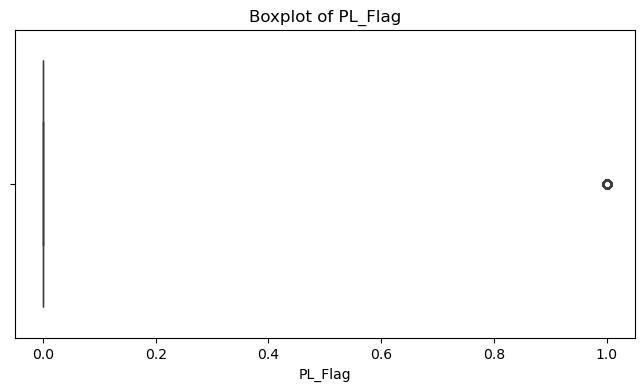

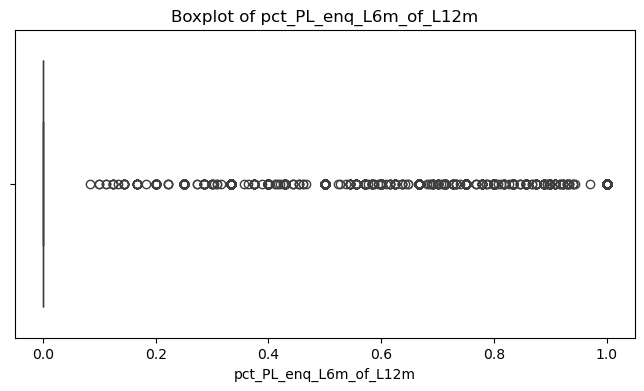

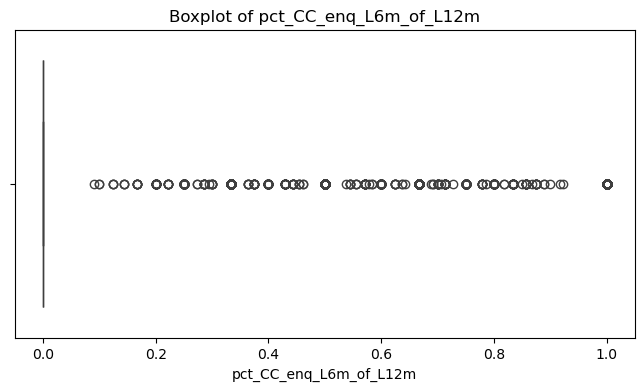

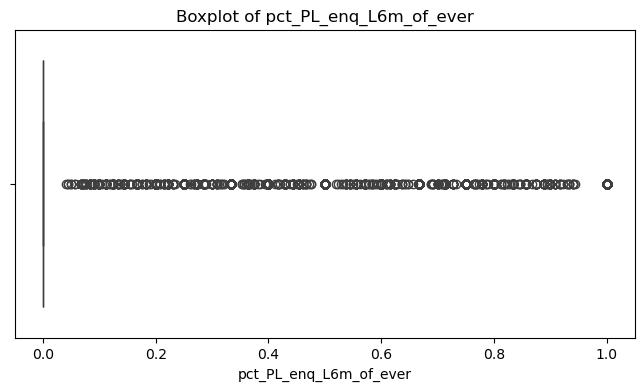

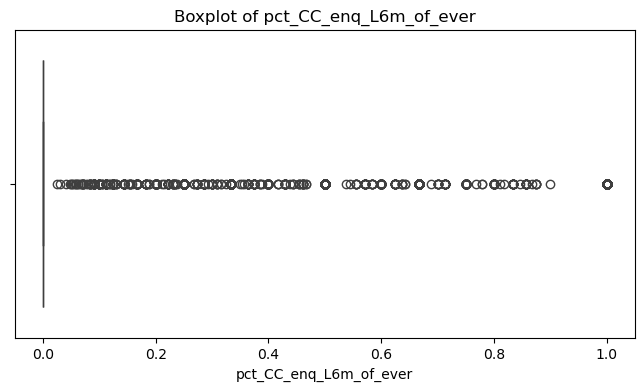

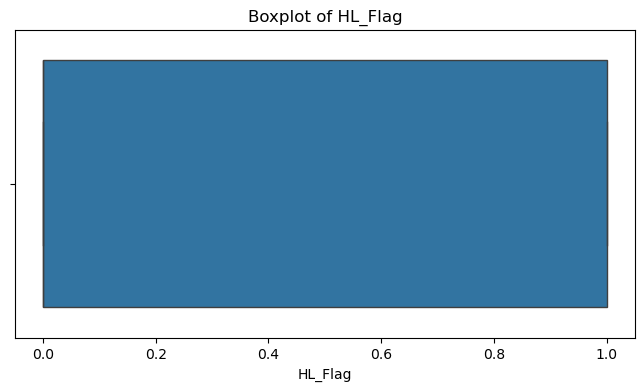

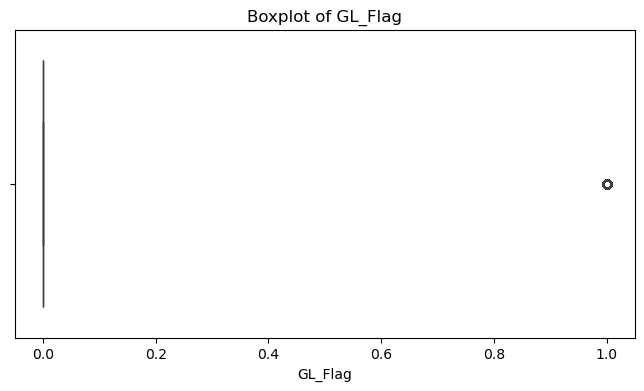

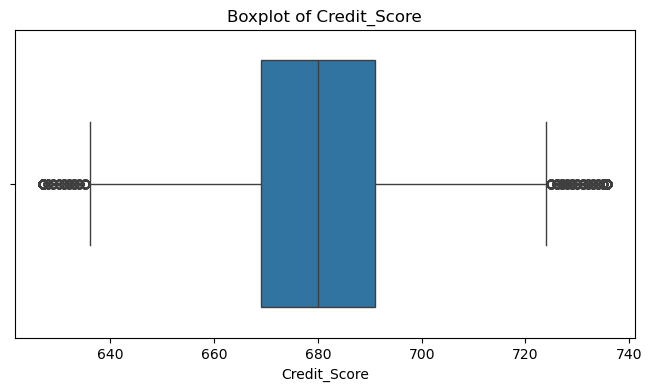

In [130]:
# Check the outliers
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

#### # Still have the outliers in the data. That's why using the IQR Method to remove them

In [38]:
def outliers_iqr(df):
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

df = outliers_iqr(df)

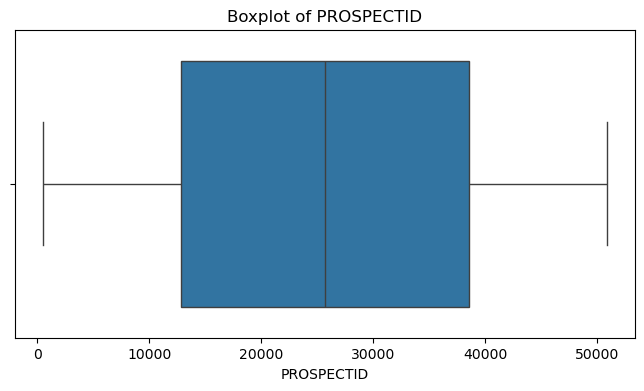

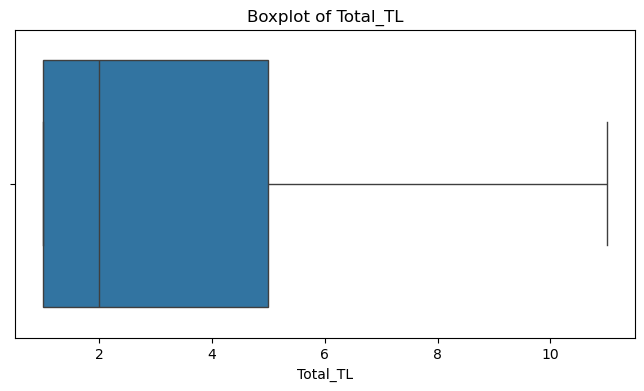

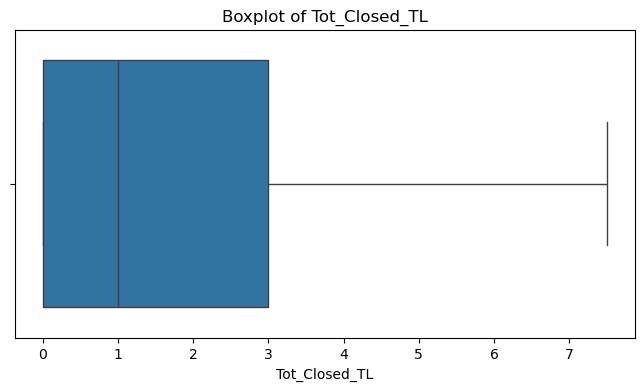

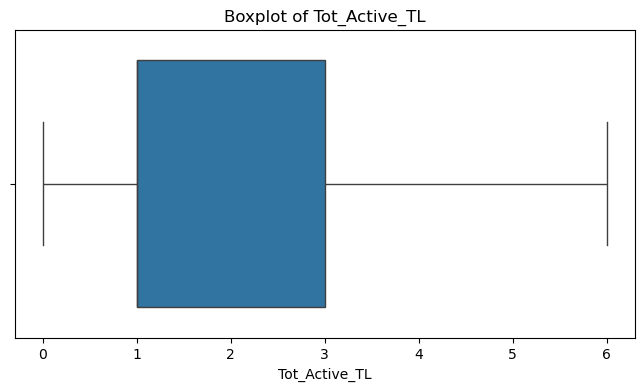

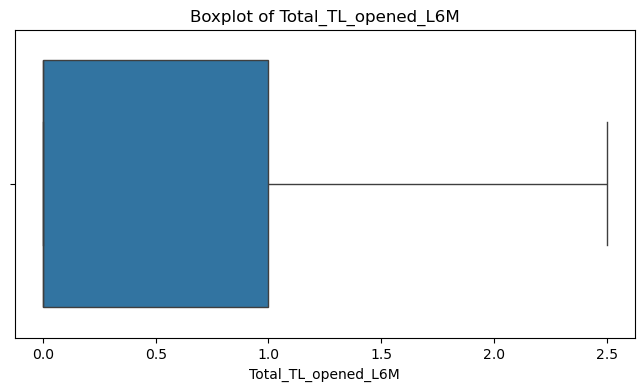

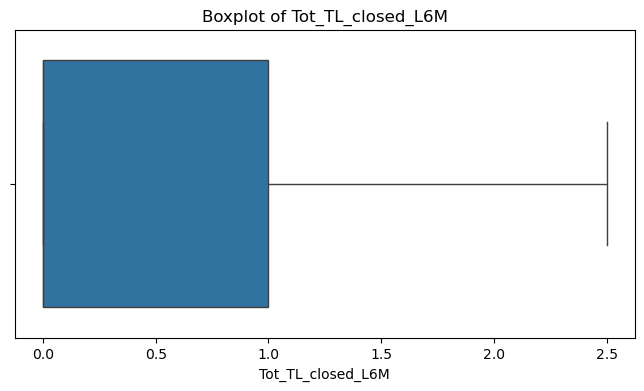

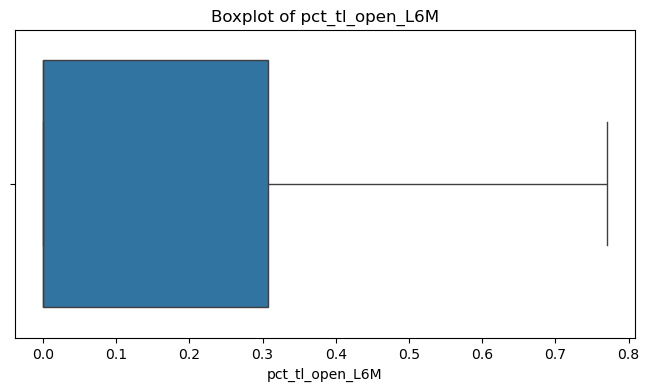

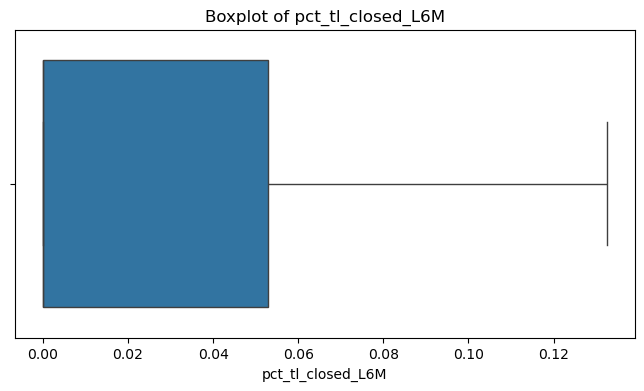

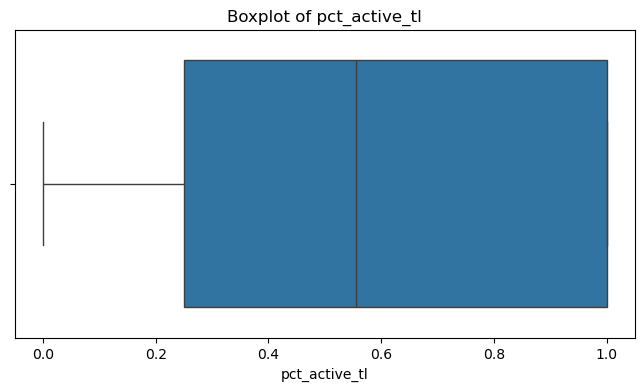

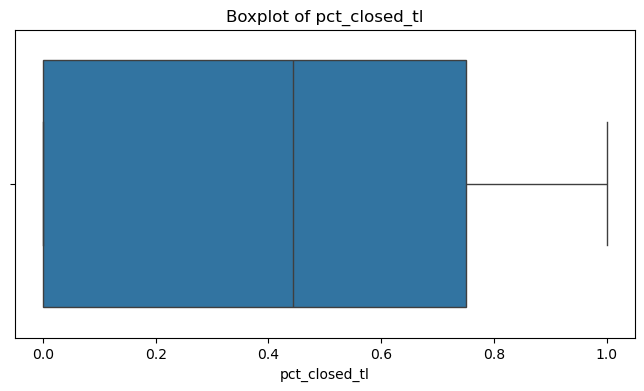

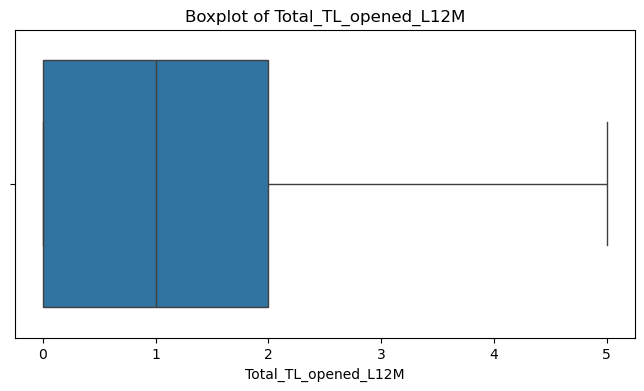

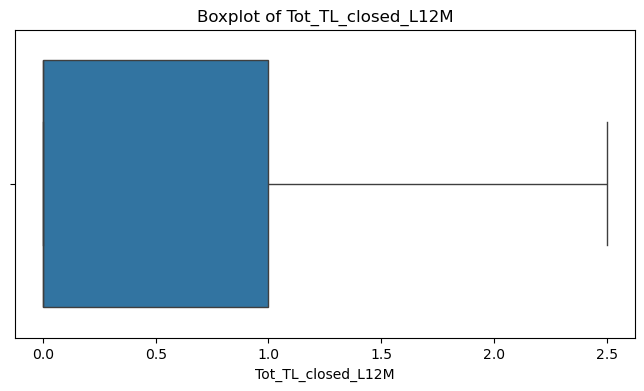

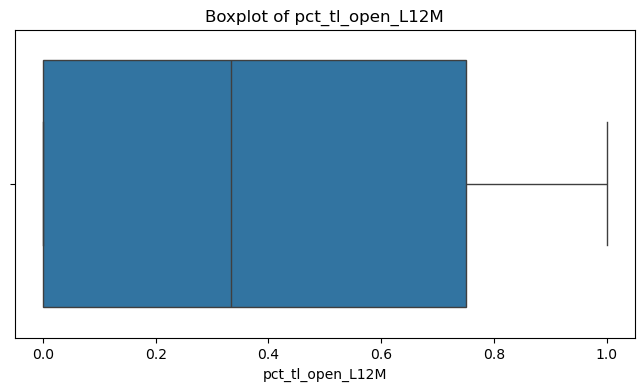

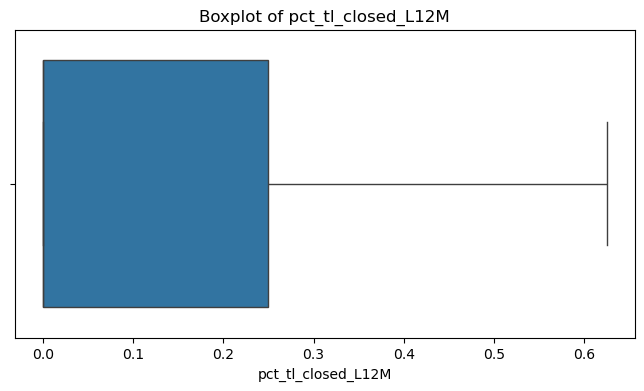

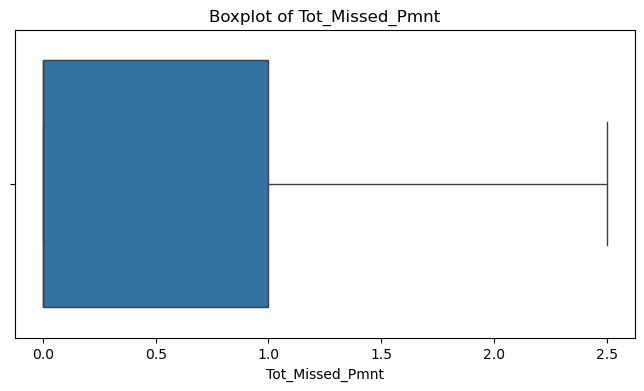

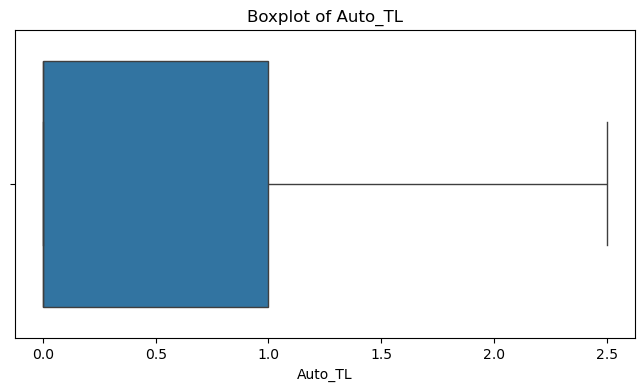

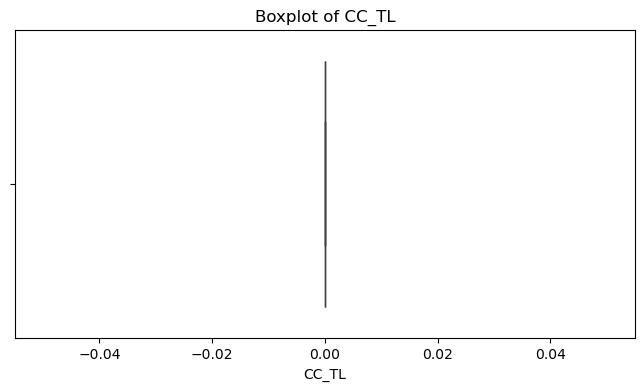

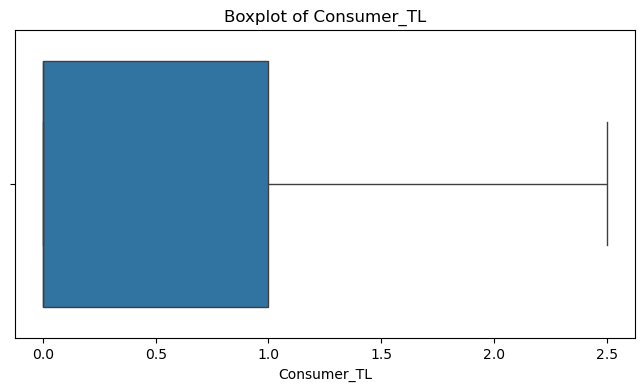

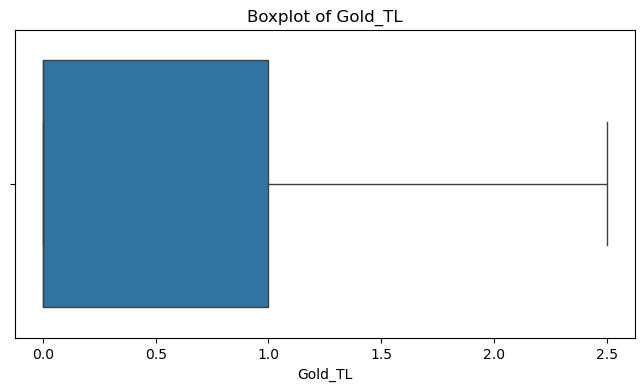

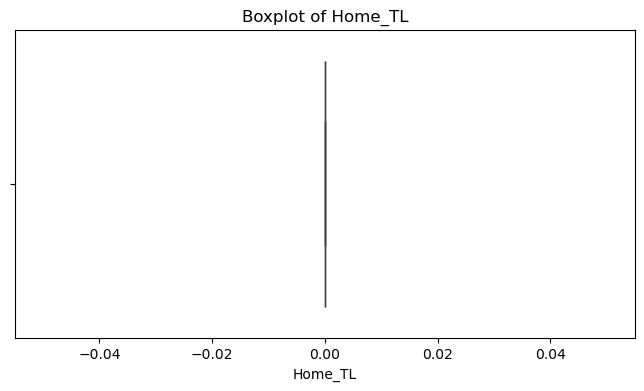

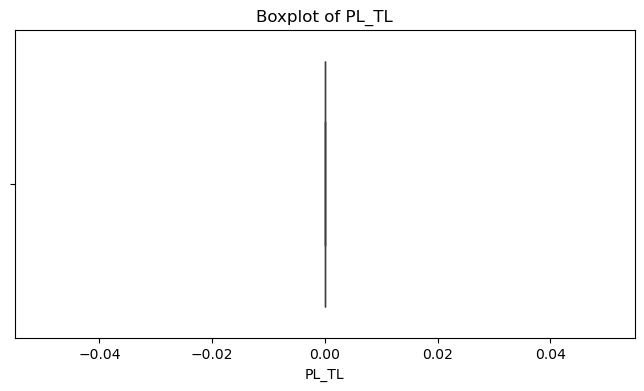

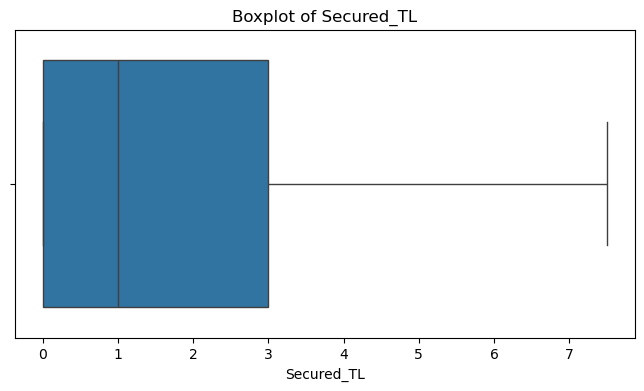

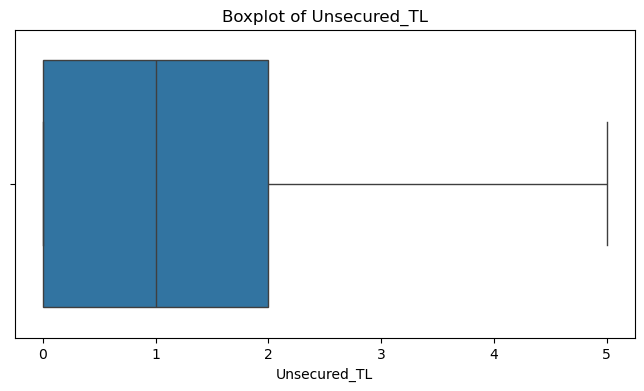

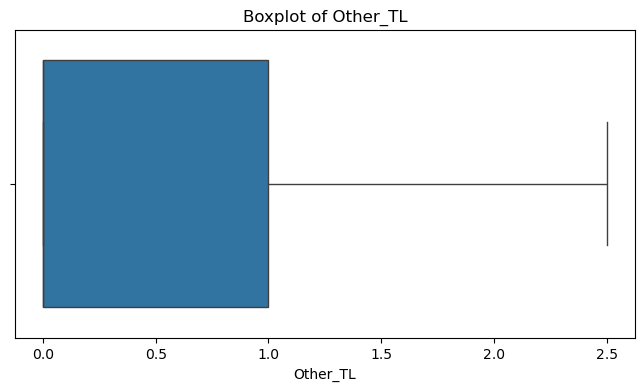

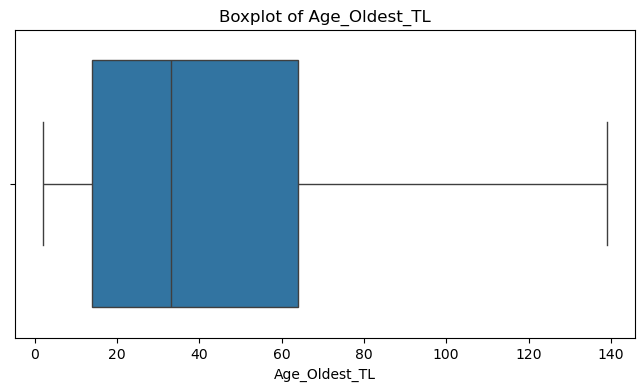

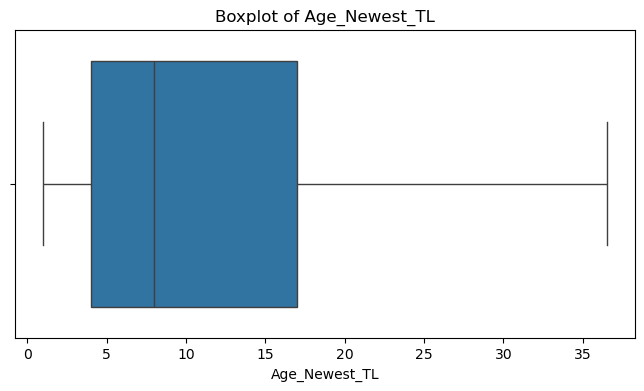

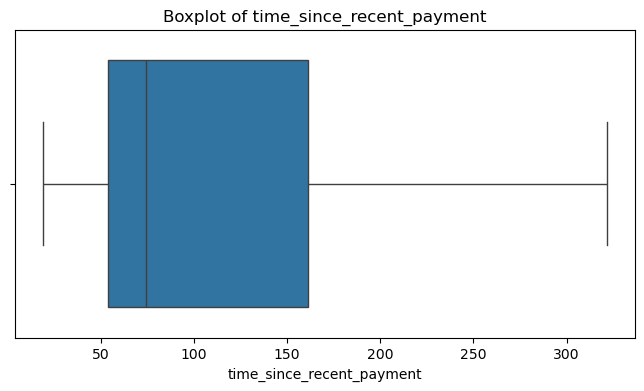

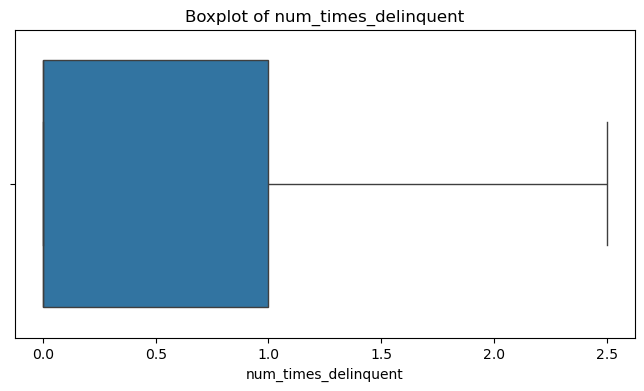

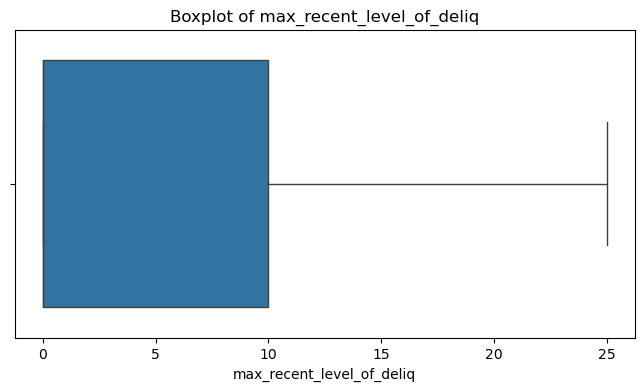

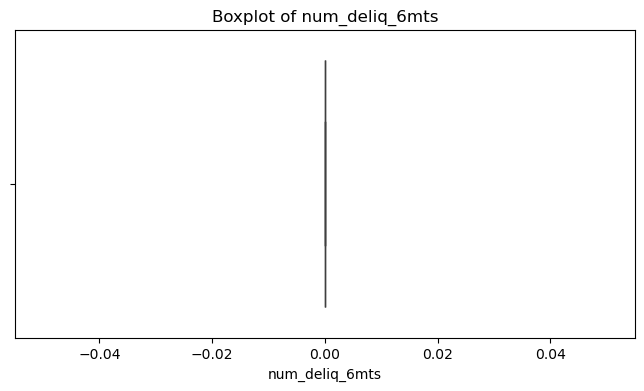

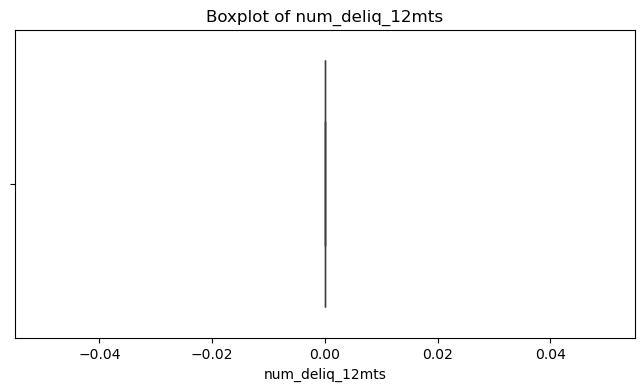

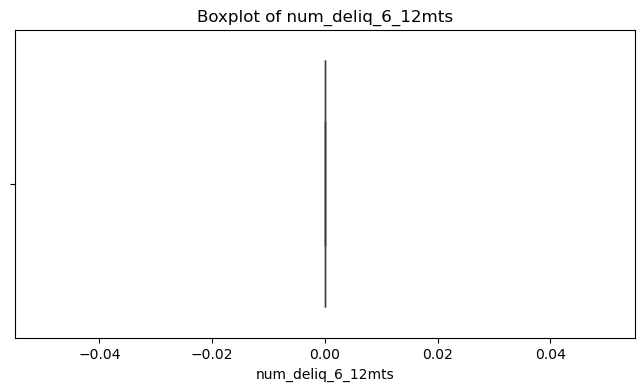

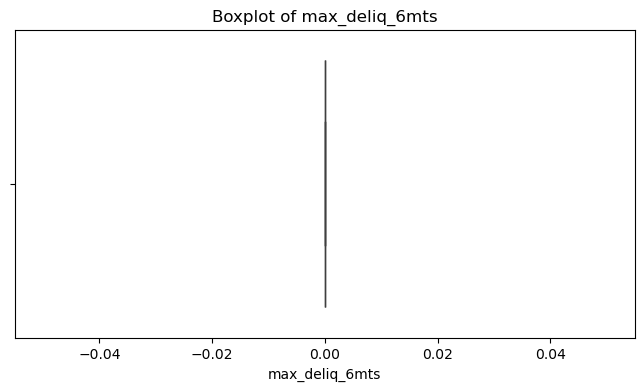

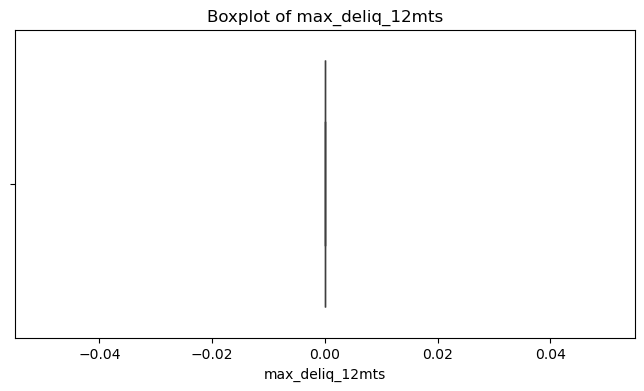

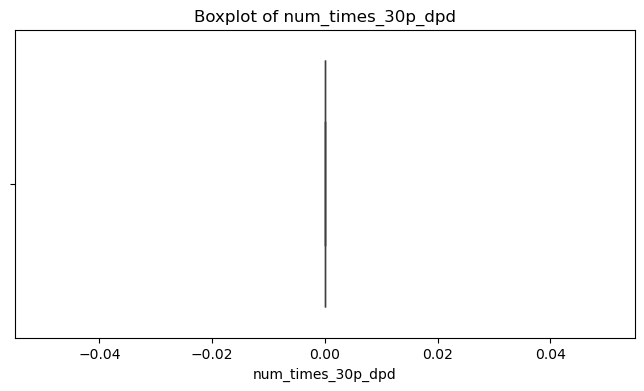

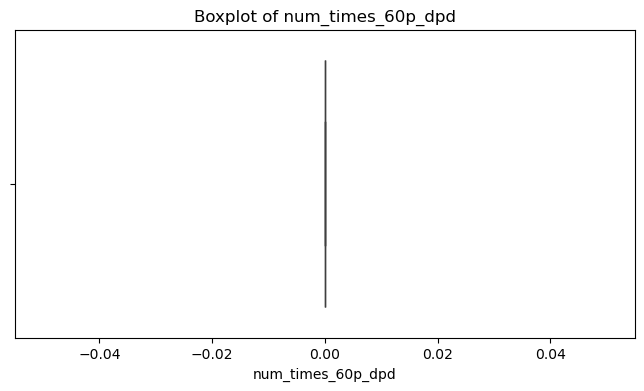

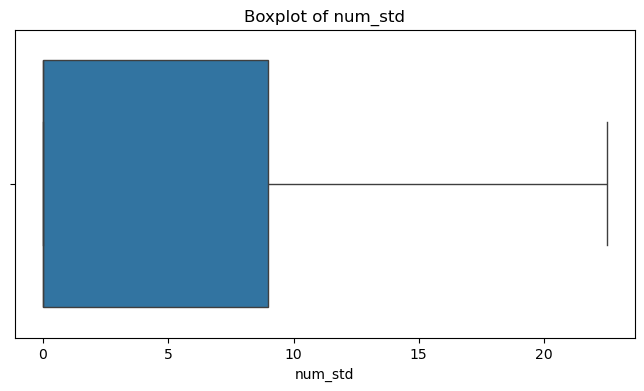

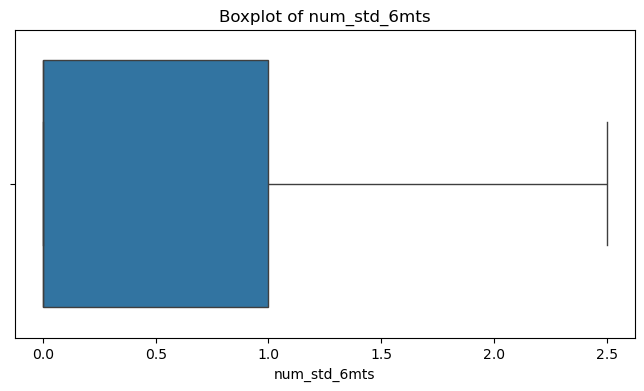

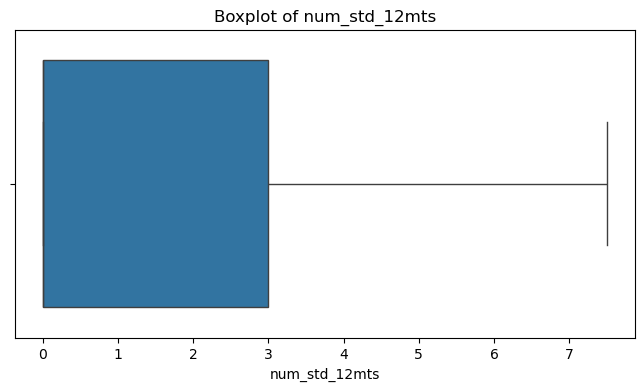

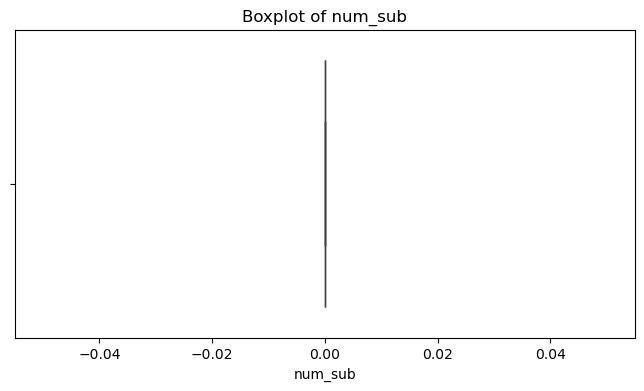

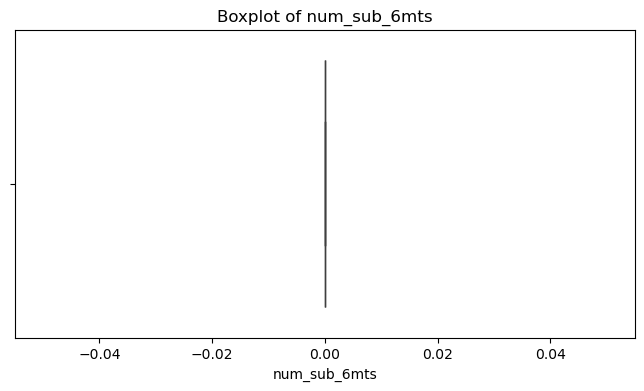

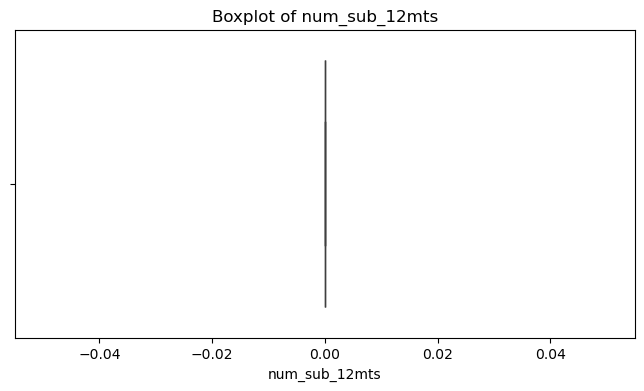

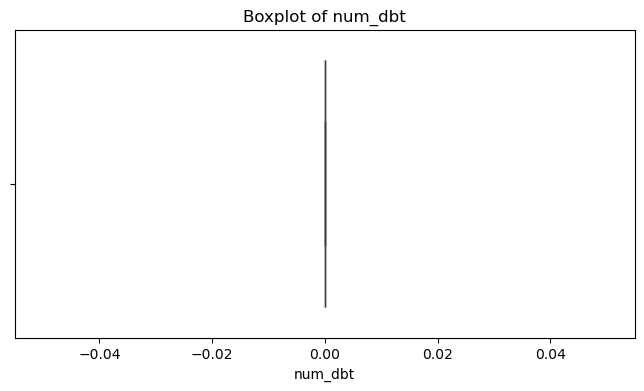

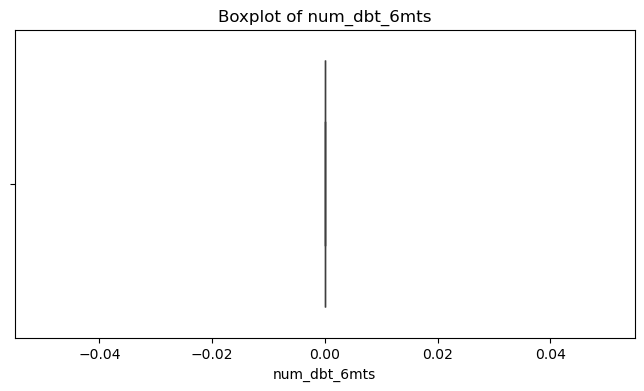

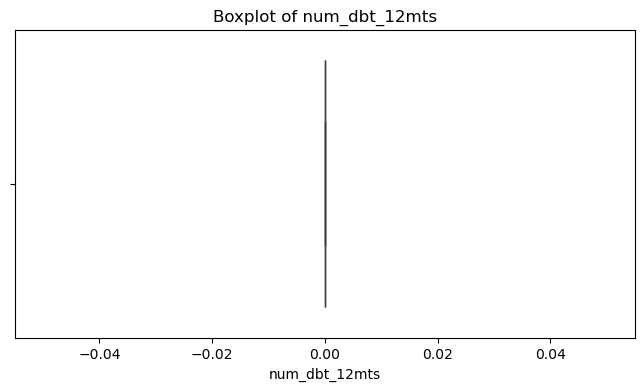

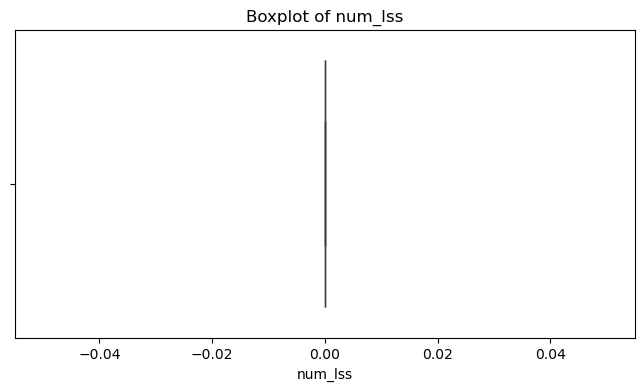

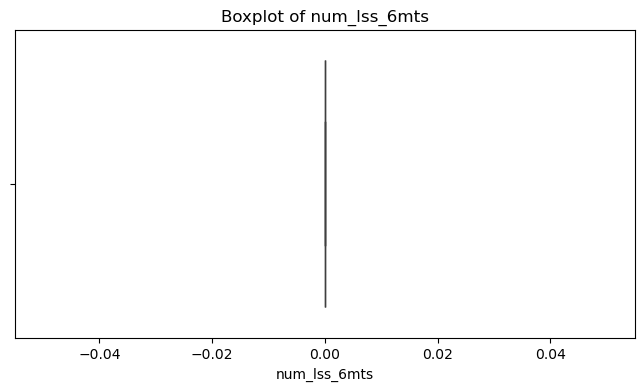

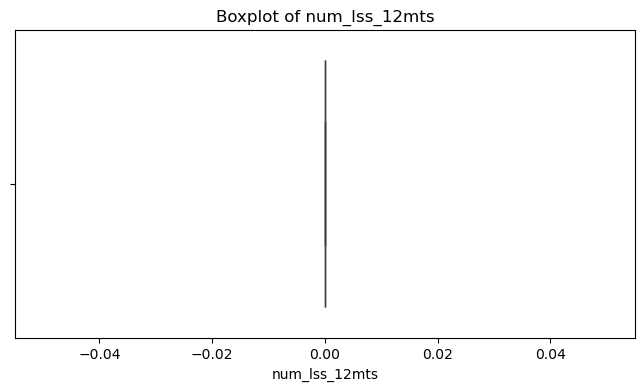

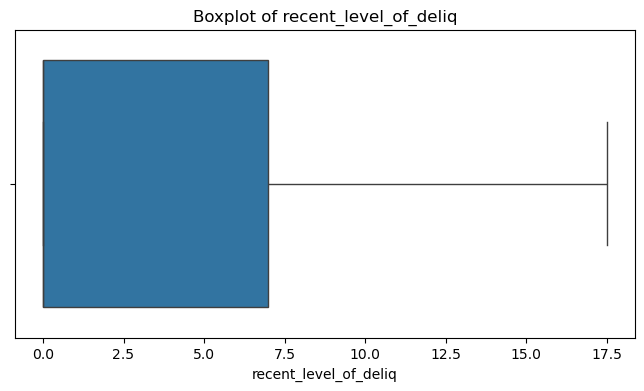

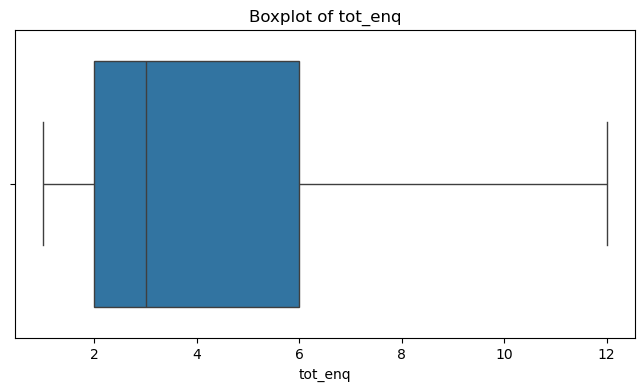

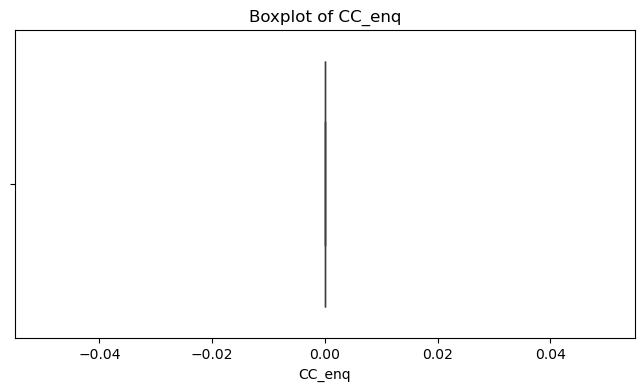

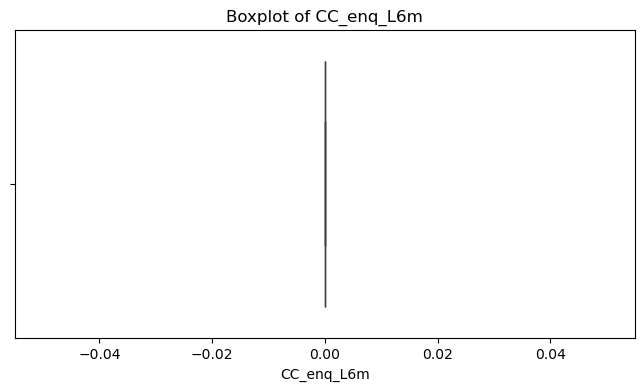

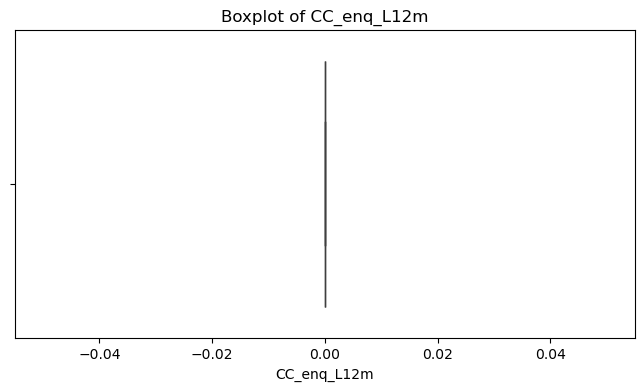

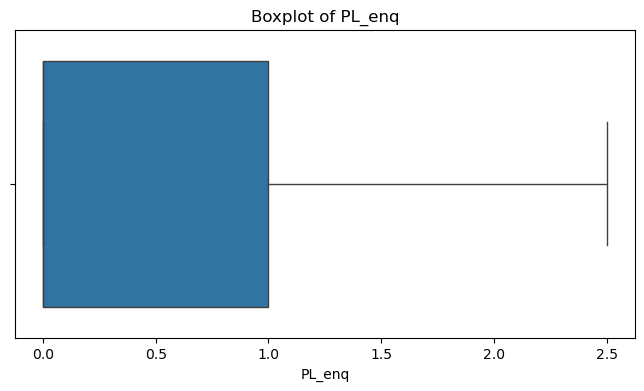

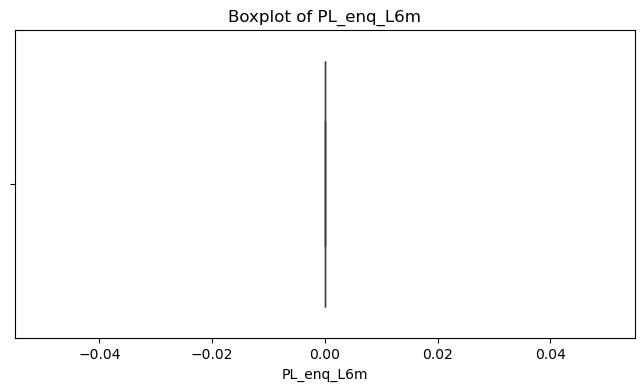

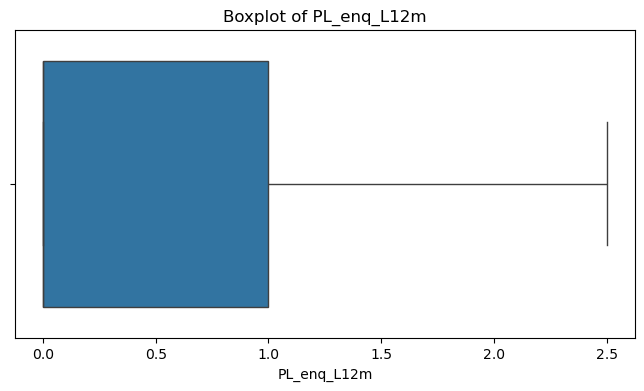

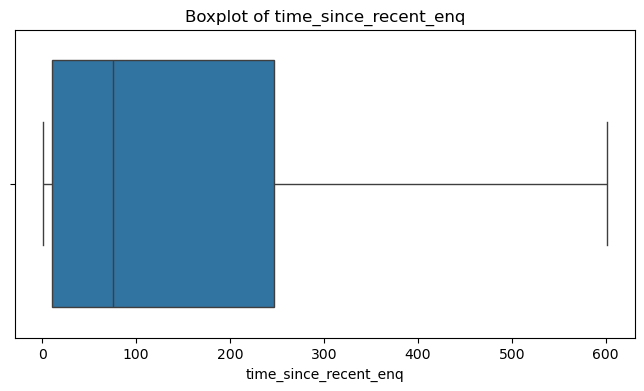

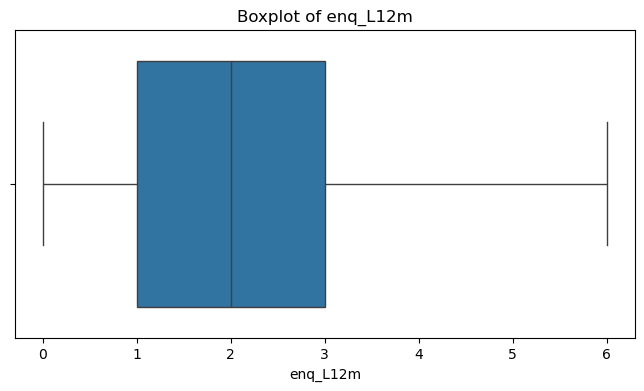

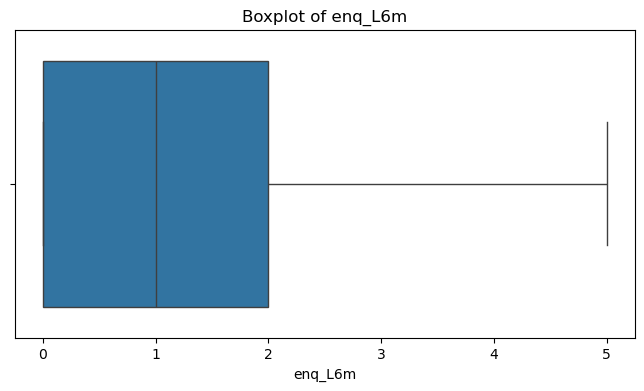

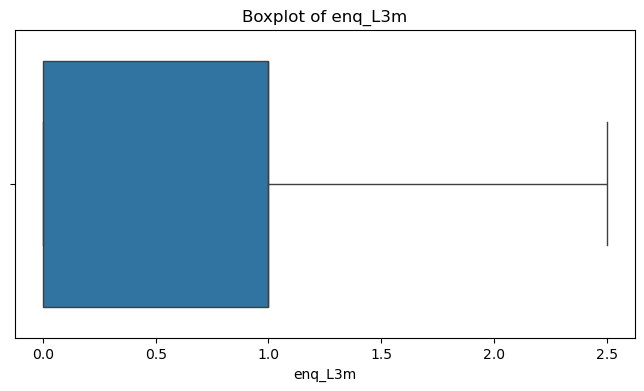

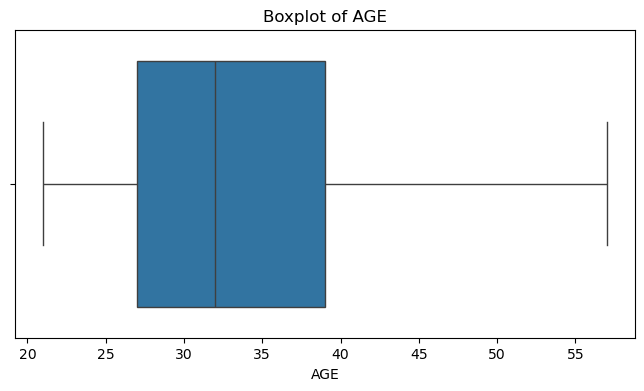

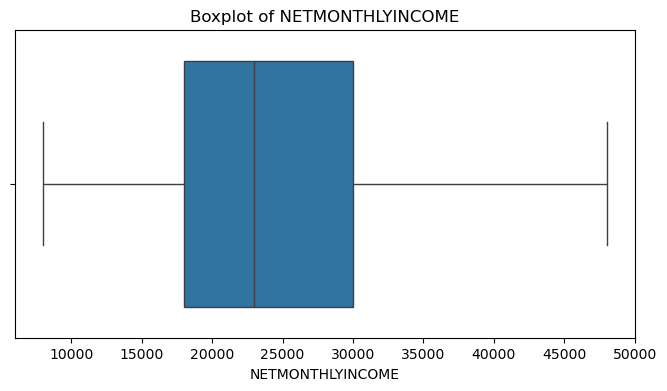

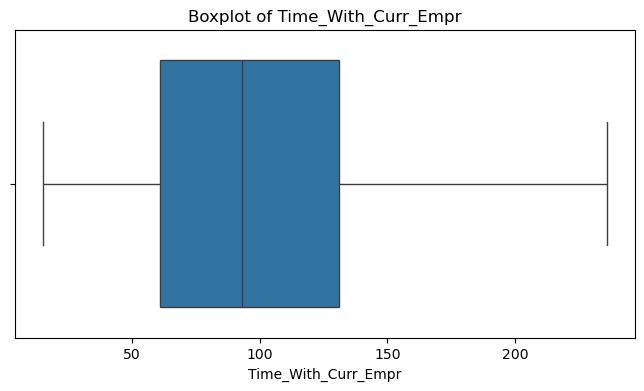

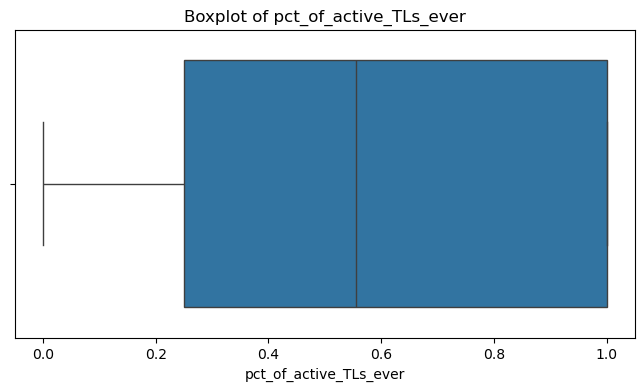

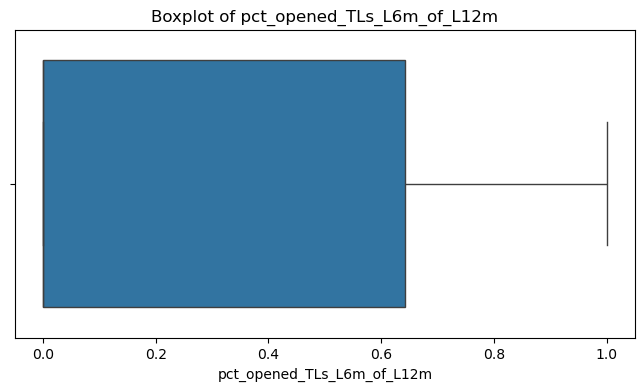

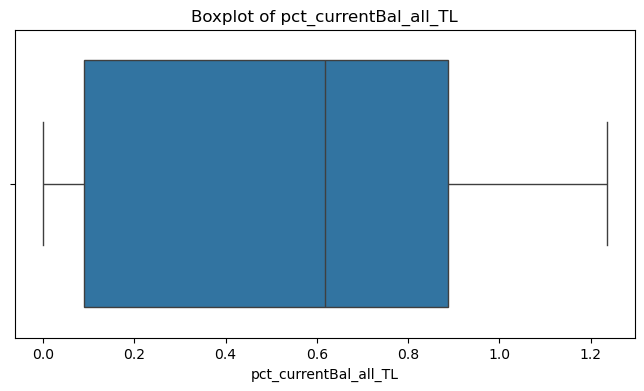

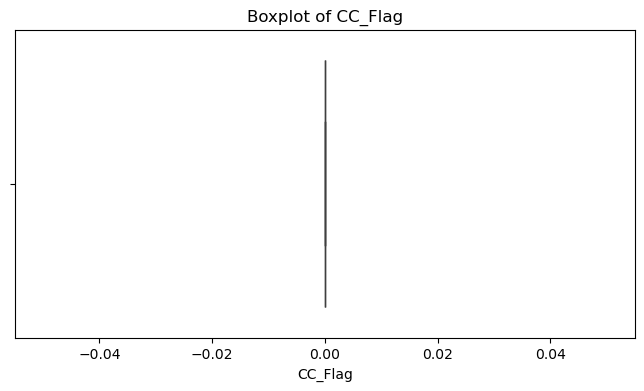

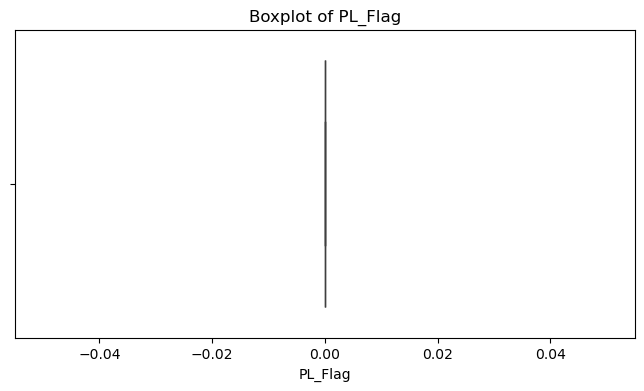

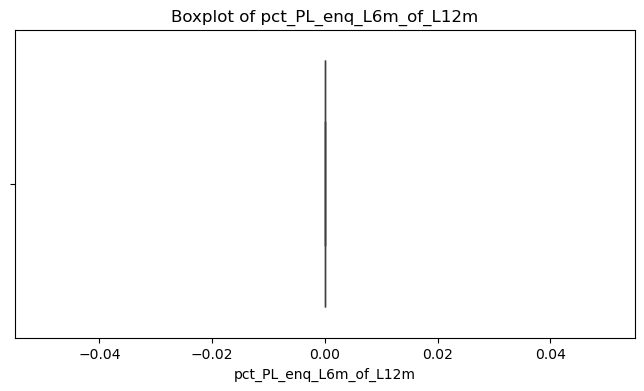

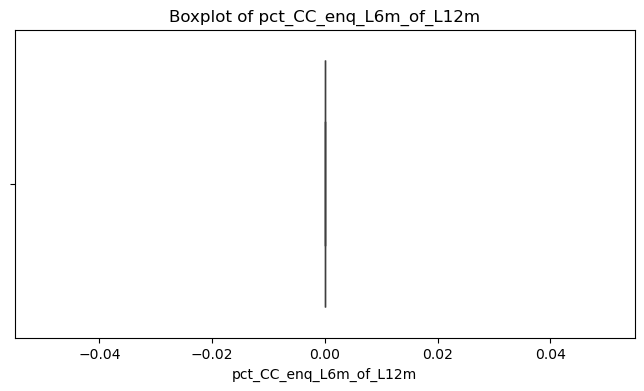

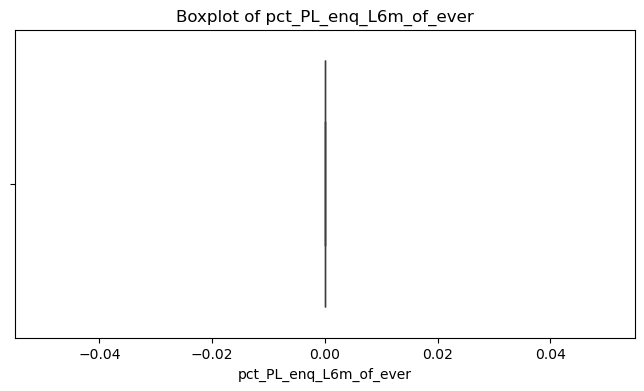

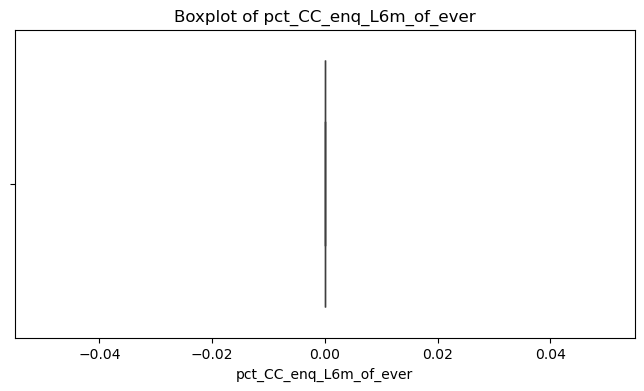

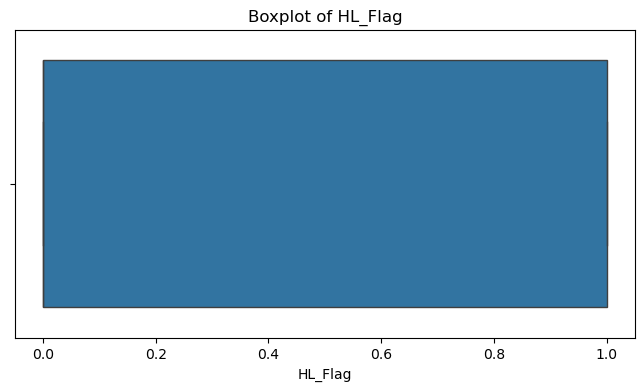

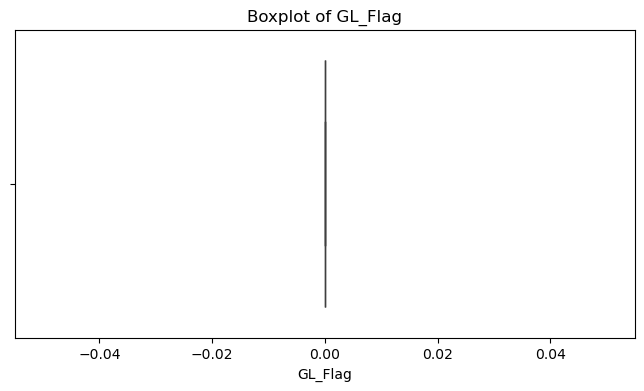

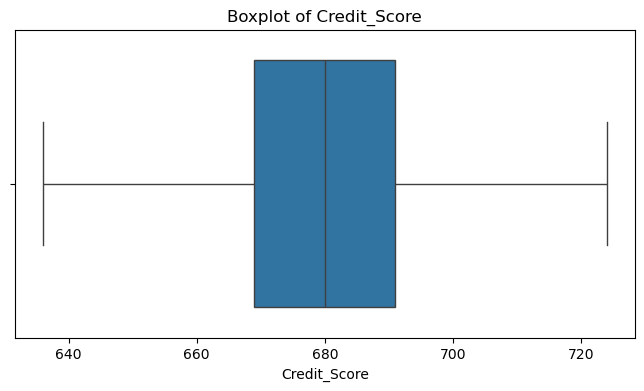

In [136]:
# Check the outliers
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [40]:
# Check how many columns are categorical
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)

MARITALSTATUS
EDUCATION
GENDER
last_prod_enq2
first_prod_enq2
Approved_Flag


In [37]:
# Label encoding for the categorical features
['MARITALSTATUS', 'EDUCATION', 'GENDER' , 'last_prod_enq2' ,'first_prod_enq2']



df['MARITALSTATUS'].unique()    
df['EDUCATION'].unique()
df['GENDER'].unique()
df['last_prod_enq2'].unique()
df['first_prod_enq2'].unique()

array(['ConsumerLoan', 'others', 'PL', 'CC', 'AL', 'HL'], dtype=object)

In [42]:
# Ordinal feature -- EDUCATION
# SSC            : 1
# 12TH           : 2
# GRADUATE       : 3
# UNDER GRADUATE : 3
# POST-GRADUATE  : 4
# OTHERS         : 1
# PROFESSIONAL   : 3

# Others has to be verified by the business end user 


df.loc[df['EDUCATION'] == 'SSC',['EDUCATION']]              = 1
df.loc[df['EDUCATION'] == '12TH',['EDUCATION']]             = 2
df.loc[df['EDUCATION'] == 'GRADUATE',['EDUCATION']]         = 3
df.loc[df['EDUCATION'] == 'UNDER GRADUATE',['EDUCATION']]   = 3
df.loc[df['EDUCATION'] == 'POST-GRADUATE',['EDUCATION']]    = 4
df.loc[df['EDUCATION'] == 'OTHERS',['EDUCATION']]           = 1
df.loc[df['EDUCATION'] == 'PROFESSIONAL',['EDUCATION']]     = 3

In [44]:
df['EDUCATION'] = df['EDUCATION'].astype(int)

In [46]:
df.shape

(51336, 81)

In [48]:
df_encoded = pd.get_dummies(df, columns=['MARITALSTATUS','GENDER', 'last_prod_enq2' ,'first_prod_enq2'])

df_encoded.info()
k = df_encoded.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 93 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PROSPECTID                    51336 non-null  float64
 1   Total_TL                      51336 non-null  float64
 2   Tot_Closed_TL                 51336 non-null  float64
 3   Tot_Active_TL                 51336 non-null  float64
 4   Total_TL_opened_L6M           51336 non-null  float64
 5   Tot_TL_closed_L6M             51336 non-null  float64
 6   pct_tl_open_L6M               51336 non-null  float64
 7   pct_tl_closed_L6M             51336 non-null  float64
 8   pct_active_tl                 51336 non-null  float64
 9   pct_closed_tl                 51336 non-null  float64
 10  Total_TL_opened_L12M          51336 non-null  float64
 11  Tot_TL_closed_L12M            51336 non-null  float64
 12  pct_tl_open_L12M              51336 non-null  float64
 13  p

In [50]:
df_encoded.shape

(51336, 93)

In [52]:
df_encoded.Approved_Flag.value_counts()

Approved_Flag
P2    32199
P3     7452
P4     5882
P1     5803
Name: count, dtype: int64

In [54]:
df_encoded.Approved_Flag.value_counts()/df_encoded.Approved_Flag.value_counts().sum()

Approved_Flag
P2    0.627221
P3    0.145161
P4    0.114578
P1    0.113040
Name: count, dtype: float64

##### # It's the case of  Imbalance Data 

#### Feature Engineering

In [56]:
# Separate x & y variable
y = df_encoded['Approved_Flag']
X = df_encoded.drop(columns=['Approved_Flag', 'PROSPECTID'])  

In [164]:
X.corr() 

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,last_prod_enq2_ConsumerLoan,last_prod_enq2_HL,last_prod_enq2_PL,last_prod_enq2_others,first_prod_enq2_AL,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others
PROSPECTID,1.000000,-0.002030,0.001131,-0.006174,-0.001397,0.004047,-0.001930,0.004844,-0.004827,0.004827,...,-0.001251,0.003900,-0.000821,0.001275,0.000481,-0.003818,-0.008113,0.001294,0.000585,0.007429
Total_TL,-0.002030,1.000000,0.889786,0.730427,0.455012,0.488812,-0.023806,0.335334,-0.306359,0.306359,...,0.022278,0.016805,0.070825,-0.108261,0.054021,0.029965,0.028630,0.037193,0.006949,-0.077651
Tot_Closed_TL,0.001131,0.889786,1.000000,0.389988,0.229918,0.490333,-0.187872,0.346343,-0.589463,0.589463,...,0.002726,0.016396,0.034155,-0.052733,0.058466,0.001278,0.027619,0.022382,0.001959,-0.059398
Tot_Active_TL,-0.006174,0.730427,0.389988,1.000000,0.630607,0.342997,0.215577,0.202513,0.234780,-0.234780,...,0.044530,0.010669,0.095989,-0.150888,0.029627,0.063341,0.023777,0.047795,0.013808,-0.083352
Total_TL_opened_L6M,-0.001397,0.455012,0.229918,0.630607,1.000000,0.391997,0.725389,0.295778,0.141582,-0.141582,...,0.098465,-0.031828,0.078281,-0.153075,-0.004648,0.035549,0.070618,-0.013244,0.032681,-0.087013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
first_prod_enq2_CC,-0.003818,0.029965,0.001278,0.063341,0.035549,-0.001691,0.032969,-0.013084,0.054337,-0.054337,...,-0.013041,-0.004759,0.011397,-0.102874,-0.051344,1.000000,-0.115650,-0.035445,-0.068454,-0.232212
first_prod_enq2_ConsumerLoan,-0.008113,0.028630,0.027619,0.023777,0.070618,0.124454,0.064211,0.135613,-0.050631,0.050631,...,0.348774,-0.043109,-0.005203,-0.292380,-0.133382,-0.115650,1.000000,-0.092080,-0.177831,-0.603239
first_prod_enq2_HL,0.001294,0.037193,0.022382,0.047795,-0.013244,-0.001349,-0.034491,-0.008876,0.021221,-0.021221,...,-0.024642,0.349383,-0.005747,-0.066951,-0.040880,-0.035445,-0.092080,1.000000,-0.054503,-0.184885
first_prod_enq2_PL,0.000585,0.006949,0.001959,0.013808,0.032681,-0.010256,0.067372,-0.012699,0.046195,-0.046195,...,-0.028102,-0.005552,0.274841,-0.166475,-0.078950,-0.068454,-0.177831,-0.054503,1.000000,-0.357063


In [166]:
X.std()/X.mean()

PROSPECTID                      0.577002
Total_TL                        0.861572
Tot_Closed_TL                   1.227150
Tot_Active_TL                   0.883256
Total_TL_opened_L6M             1.381740
                                  ...   
first_prod_enq2_CC              4.739511
first_prod_enq2_ConsumerLoan    1.824435
first_prod_enq2_HL              5.952734
first_prod_enq2_PL              3.082287
first_prod_enq2_others          0.908637
Length: 92, dtype: float64

In [58]:
# RFE - Recursive Feature Elimination 
classifier = RandomForestClassifier()
rfe  = RFE(estimator = classifier, n_features_to_select = 10)
rfe = rfe.fit(X,y)

In [60]:
X.columns[rfe.support_]

Index(['Total_TL', 'Age_Oldest_TL', 'num_std', 'num_std_12mts',
       'recent_level_of_deliq', 'time_since_recent_enq', 'enq_L12m', 'enq_L6m',
       'enq_L3m', 'Credit_Score'],
      dtype='object')

In [170]:
X.columns[rfe.support_]

Index(['PROSPECTID', 'Age_Oldest_TL', 'max_recent_level_of_deliq', 'num_std',
       'num_std_12mts', 'time_since_recent_enq', 'enq_L12m', 'enq_L6m',
       'enq_L3m', 'Credit_Score'],
      dtype='object')

#### Select KBEST

In [62]:
SKB = SelectKBest(f_classif, k=15)

In [64]:
X_XKB = SKB.fit_transform(X, y)

C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [15 18 19 28 29 30 31 32 33 34 38 39 40 41 42 43 44 45 46 49 50 51 53 66
 67 68 69 70 71 73] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [66]:
X.columns[SKB.get_support()]

Index(['Total_TL', 'Tot_Closed_TL', 'Secured_TL', 'Age_Oldest_TL', 'num_std',
       'num_std_6mts', 'num_std_12mts', 'tot_enq', 'PL_enq', 'PL_enq_L12m',
       'time_since_recent_enq', 'enq_L12m', 'enq_L6m', 'enq_L3m',
       'Credit_Score'],
      dtype='object')

In [179]:
X.columns[SKB.get_support()]

Index(['Total_TL', 'Tot_Closed_TL', 'Secured_TL', 'Age_Oldest_TL', 'num_std',
       'num_std_6mts', 'num_std_12mts', 'tot_enq', 'PL_enq', 'PL_enq_L12m',
       'time_since_recent_enq', 'enq_L12m', 'enq_L6m', 'enq_L3m',
       'Credit_Score'],
      dtype='object')

In [68]:
X_new = X[list(set(list(X.columns[rfe.support_]) + list(X.columns[SKB.get_support()])))]

In [70]:
X_new.shape

(51336, 16)

In [74]:
X_new.columns

Index(['recent_level_of_deliq', 'Credit_Score', 'tot_enq', 'Secured_TL',
       'PL_enq_L12m', 'enq_L12m', 'Total_TL', 'time_since_recent_enq',
       'enq_L6m', 'num_std_6mts', 'num_std_12mts', 'enq_L3m', 'Age_Oldest_TL',
       'PL_enq', 'Tot_Closed_TL', 'num_std'],
      dtype='object')

In [72]:
# Feature Scaling
scaler=StandardScaler()

X=scaler.fit_transform(X_new)

In [76]:
X = pd.DataFrame(X, columns = ['recent_level_of_deliq', 'Credit_Score', 'tot_enq', 'Secured_TL',
       'PL_enq_L12m', 'enq_L12m', 'Total_TL', 'time_since_recent_enq',
       'enq_L6m', 'num_std_6mts', 'num_std_12mts', 'enq_L3m', 'Age_Oldest_TL',
       'PL_enq', 'Tot_Closed_TL', 'num_std'])

In [195]:
X = pd.DataFrame(X, columns = ['Age_Oldest_TL', 'enq_L3m', 'Total_TL', 'num_std_6mts', 'num_std_12mts',
       'max_recent_level_of_deliq', 'Credit_Score', 'Tot_Closed_TL', 'num_std',
       'enq_L12m', 'tot_enq', 'PL_enq', 'PROSPECTID', 'PL_enq_L12m', 'enq_L6m',
       'Secured_TL', 'time_since_recent_enq'])

### 6. Machine Learning 
#### Model Building

#### 1. Logistic Regression

In [78]:
# Separate x & y variable
y = df_encoded['Approved_Flag']
x = X  

In [80]:
# Split the data into: Train & Test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [82]:
from sklearn.linear_model import LogisticRegression

In [84]:
LR = LogisticRegression()
LR.fit(x_train, y_train)
pred = LR.predict(x_test)

C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
accuracy_score(y_test,pred)

0.9586092715231788

In [88]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

          P1       0.98      0.97      0.97      1120
          P2       0.95      0.99      0.97      6440
          P3       0.96      0.78      0.86      1548
          P4       1.00      1.00      1.00      1160

    accuracy                           0.96     10268
   macro avg       0.97      0.94      0.95     10268
weighted avg       0.96      0.96      0.96     10268



#### 2. Random Forest 

In [90]:
# Separate x & y variable
y = df_encoded['Approved_Flag']
x = X  

In [92]:
# Split the data into: Train & Test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [94]:
# Define & Fit the model
rf_classifier = RandomForestClassifier(n_estimators = 200, random_state=42)
rf_classifier.fit(x_train, y_train)
y_pred_rf = rf_classifier.predict(x_test)

In [96]:
accuracy_score(y_test,y_pred_rf)

0.994838332684067

In [98]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

          P1       0.98      0.97      0.98      1120
          P2       1.00      1.00      1.00      6440
          P3       0.98      0.99      0.98      1548
          P4       1.00      1.00      1.00      1160

    accuracy                           0.99     10268
   macro avg       0.99      0.99      0.99     10268
weighted avg       0.99      0.99      0.99     10268



#### 3. XGBoost 

In [100]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

xgb_classifier = xgb.XGBClassifier(objective='multi:softmax',  num_class=4)

In [102]:
# Separate the x & y variables
y = df_encoded['Approved_Flag']
x = X 

In [104]:
# Lable encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [106]:
# Split the data into: Train & test
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

In [108]:
# Define & Fit the Model
xgb_classifier.fit(x_train, y_train)
y_pred_xgb = xgb_classifier.predict(x_test)

In [110]:
accuracy_score(y_test,y_pred_xgb)  

0.9951305025321386

In [112]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1120
           1       1.00      1.00      1.00      6440
           2       0.98      0.99      0.98      1548
           3       1.00      1.00      1.00      1160

    accuracy                           1.00     10268
   macro avg       0.99      0.99      0.99     10268
weighted avg       1.00      1.00      1.00     10268



#### 4. Decision Tree

In [114]:
from sklearn.tree import DecisionTreeClassifier

In [116]:
# Separate the x & y variables
y = df_encoded['Approved_Flag']
x = X 

In [118]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [120]:
dt_model = DecisionTreeClassifier(max_depth=20, min_samples_split=10)
dt_model.fit(x_train, y_train)
y_pred_dt = dt_model.predict(x_test)

In [122]:
accuracy_score(y_test,y_pred_dt)

0.9947409427347098

In [124]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

          P1       0.98      0.98      0.98      1120
          P2       1.00      1.00      1.00      6440
          P3       0.98      0.98      0.98      1548
          P4       1.00      1.00      1.00      1160

    accuracy                           0.99     10268
   macro avg       0.99      0.99      0.99     10268
weighted avg       0.99      0.99      0.99     10268



In [135]:
# Import pickle and save the object
import pickle

# Save to a pickle file
with open('Model.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

In [133]:
X.columns

Index(['recent_level_of_deliq', 'Credit_Score', 'tot_enq', 'Secured_TL',
       'PL_enq_L12m', 'enq_L12m', 'Total_TL', 'time_since_recent_enq',
       'enq_L6m', 'num_std_6mts', 'num_std_12mts', 'enq_L3m', 'Age_Oldest_TL',
       'PL_enq', 'Tot_Closed_TL', 'num_std'],
      dtype='object')